<a href="https://colab.research.google.com/github/yingzibu/drug_design_JAK/blob/main/drugVAE/smile_tokenize_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
cuda = torch.cuda.is_available()
cuda

True

In [26]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display

from tqdm import tqdm

# import pandas as pd
# chembl_path = '/content/drive/MyDrive/A_DATA/filtered_chembl_for_gentrl.csv'
# chembl = pd.read_csv(chembl_path)


import torch
import re


_atoms = ['He', 'Li', 'Be', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'Cl', 'Ar',
          'Ca', 'Ti', 'Cr', 'Fe', 'Ni', 'Cu', 'Ga', 'Ge', 'As', 'Se',
          'Br', 'Kr', 'Rb', 'Sr', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
          'Pd', 'Ag', 'Cd', 'Sb', 'Te', 'Xe', 'Ba', 'La', 'Ce', 'Pr',
          'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Er', 'Tm', 'Yb',
          'Lu', 'Hf', 'Ta', 'Re', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb',
          'Bi', 'At', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'Pu', 'Am', 'Cm',
          'Bk', 'Cf', 'Es', 'Fm', 'Md', 'Lr', 'Rf', 'Db', 'Sg', 'Mt',
          'Ds', 'Rg', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']


def get_tokenizer_re(atoms):
    return re.compile('('+'|'.join(atoms)+r'|\%\d\d|.)')


_atoms_re = get_tokenizer_re(_atoms)


__i2t = {
    0: 'unused', 1: '>', 2: '<', 3: '2', 4: 'F', 5: 'Cl', 6: 'N',
    7: '[', 8: '6', 9: 'O', 10: 'c', 11: ']', 12: '#',
    13: '=', 14: '3', 15: ')', 16: '4', 17: '-', 18: 'n',
    19: 'o', 20: '5', 21: 'H', 22: '(', 23: 'C',
    24: '1', 25: 'S', 26: 's', 27: 'Br' , 28: '@', 29: '/', 30: '.',
    31: 'P', 32: '+', 33: 'I', 34: 'Si', 35: 'B', 36: '\\',
    37: '7', 38: '8', 39: '9'
}
# 28: '@', 29: '/', 30: '.'

__t2i = {
    '>': 1, '<': 2, '2': 3, 'F': 4, 'Cl': 5, 'N': 6, '[': 7, '6': 8,
    'O': 9, 'c': 10, ']': 11, '#': 12, '=': 13, '3': 14, ')': 15,
    '4': 16, '-': 17, 'n': 18, 'o': 19, '5': 20, 'H': 21, '(': 22,
    'C': 23, '1': 24, 'S': 25, 's': 26, 'Br': 27 , '@': 28, '/': 29, '.': 30,
    'P': 31, '+': 32, 'I': 33, 'Si': 34, 'B': 35, '\\': 36,
    '7': 37, '8': 38, '9': 39
}
#, '@': 28, '/': 29, '.': 30

def smiles_tokenizer(line, atoms=['Cl', 'Br', 'Si', 'Na', 'Mg']):
    """
    Tokenizes SMILES string atom-wise using regular expressions. While this
    method is fast, it may lead to some mistakes: Sn may be considered as Tin
    or as Sulfur with Nitrogen in aromatic cycle. Because of this, you should
    specify a set of two-letter atoms explicitly.

    Parameters:
         atoms: set of two-letter atoms for tokenization
    """
    if atoms is not None:
        reg = get_tokenizer_re(atoms)
    else:
        reg = _atoms_re
    return reg.split(line)[1::2]




def encode(sm_list, pad_size=200):
    """
    Encoder list of smiles to tensor of tokens
    """
    res = []
    lens = []
    for s in sm_list:

        tokens = ([1] + [__t2i[tok]
                for tok in smiles_tokenizer(s)])
        lens.append(len(tokens))
        tokens = tokens[:pad_size - 1]
        tokens += (pad_size - len(tokens)) * [2]
        res.append(tokens)

    return torch.tensor(res).long(), lens


def decode(tokens_tensor):
    """
    Decodes from tensor of tokens to list of smiles
    """

    smiles_res = []

    for i in range(tokens_tensor.shape[0]):
        cur_sm = ''
        for t in tokens_tensor[i].detach().cpu().numpy():
            if t == 2:
                break
            elif t > 2:
                cur_sm += __i2t[t]

        smiles_res.append(cur_sm)

    return smiles_res


def get_vocab_size():
    return len(__i2t)


In [23]:
chembl = '/content/drive/MyDrive/A_DATA/filtered_chembl_for_gentrl.csv'
drug = pd.read_csv(chembl)
drug.head()

SMILES      plogP       QED
0                       Cc1cc(-c2csc(N=C(N)N)n2)cn1C  -1.686554  0.608781
1  CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H... -25.745690  0.016357
2  CCCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(... -22.948679  0.010798
3  CC(C)C[C@@H]1NC(=O)CNC(=O)[C@H](c2ccc(O)cc2)NC... -15.732651  0.016726
4             Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1   0.679815  0.623114

In [22]:
def To_matrix(t: torch.Tensor, vocab_size=get_vocab_size()):
    """
    max len = 120 as default
    Convert torch.Tensor of size (len_mol, max_len) to
    torch.Tensor of (len_mol, vocab_size, max_len)
    :param t: tensor of size (len_mol, max_len)
    :return (len_mol, max_len, vocab_size)
    """
    # print(t.shape)
    assert len(t.size()) == 2 # still vector

    output = torch.zeros([t.shape[0], t.shape[1], vocab_size])


    for i in range(t.shape[0]):
        temp = t[i] # (max_len), one drug
        for j, value in enumerate(temp):
            output[i][j][value] = 1

    device_t = t.device.type

    output = output.to(device_t)

    return output

def To_vector(mat: torch.Tensor):
    """
    :param mat: (len_mol, max_len, vocab_size)
    : Return back to array
    """
    len_mol, max_len, vocab_size = mat.shape
    output = torch.zeros([len_mol, max_len])

    for i in range(mat.shape[0]):
        temp = mat[i]
        # print(temp.shape) [max_len, vocab_size]
        pos = torch.argmax(temp, dim=1) # size [120]
        # print(pos.shape)

        output[i] = pos

    device_mat = mat.device.type
    output = output.to(device_mat)
    return output


In [25]:
def encode(sm_list, pad_size=200):
    """
    Encoder list of smiles to tensor of tokens
    """
    res = []
    lens = []
    inv = []
    for s in tqdm(sm_list, total=len(sm_list)):
        try:
            tokens = ([1] + [__t2i[tok]
                    for tok in smiles_tokenizer(s)])
            lens.append(len(tokens))
            tokens = tokens[:pad_size - 1]
            tokens += (pad_size - len(tokens)) * [2]
            res.append(tokens)
        except:
            inv.append(s)
            pass
    return torch.tensor(res).long(), lens

In [47]:
save_path = '/content/drive/MyDrive/A_DATA/smile_len_200/'
M = Chem.MolFromSmiles
S = Chem.MolToSmiles

pad_size = 120

# lens = []


smiles = drug.SMILES





def convert_dataset(smiles, pad_size, save_path=save_path):
    valid_smiles = []
    inv = []
    res = [] # token_list
    for s in tqdm(smiles):
        try:
            tokens = ([1] + [__t2i[tok]
                    for tok in smiles_tokenizer(s)])
            if len(tokens) < pad_size:
                valid_smiles.append(s)
            # lens.append(len(tokens))
                tokens = tokens[:pad_size - 1]
                tokens += (pad_size - len(tokens)) * [2]
                res.append(tokens)
            else: inv.append(s)
        except:
            # inv.append(s)
            pass
    # smiles = valid_smiles
    with open(save_path+f'valid_smi_{str(pad_size)}.pkl') as f:
        pickle.dump(valid_smiles, f)

    tens = torch.tensor(res).long()
    tensor_path = save_path + f'vector_{str(pad_size)}.pt'
    torch.save(tens, tensor_path)
    print('vector saved at: ', tensor_path)
    print(f'compounds length >= {pad_size}: ', inv)

    tens_temp = torch.load(tensor_path)
    print(f'reload vector size: ', tens_temp.shape)
    smis_re_ = decode(tens_temp)

    num = 0

    perfect_smis = []
    enc_dec_inv = []
    for i, j in tqdm(zip(smis_re_, valid_smiles), total=len(smis_re_)):
        try:
            smi = S(M(i))
        except:
            num += 1
            inv.append(smi)
        try:
            assert i == j
            perfect_smis.append(j)
        except:
            enc_dec_inv.append(j)

    with open(save_path+f'invalid_smi_{str(pad_size)}.pkl') as f:
        pickle.dump(inv, f)

    with open(save_path+f'invalid_enc_dec_{str(pad_size)}.pkl') as f:
        pickle.dump(enc_dec_inv, f)

    print('cannot use smi->mol->smi num:', num)
    print('invalid compound num: ', len(inv))
    print('cannot enc_dec through alphabet: ', len(enc_dec_inv))


# print('cannot ', num)
# /content/drive/MyDrive/A_DATA/smile_len_200

In [54]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [55]:
import random
smiles_sample = random.sample(sorted(smiles), 100)
convert_dataset(smiles_sample, pad_size=120, save_path = 'A_DATA/smile_len_200/')

100%|██████████| 100/100 [00:00<00:00, 42672.74it/s]


FileNotFoundError: ignored

In [50]:
ls

dataloader.py  encoder.py  __init__.py  __pycache__/
decoder.py     gentrl.py   lp.py        tokenizer.py


In [38]:
print('compounds length >= 200: ', inv)

compounds length >= 200:  31038


In [29]:
import pickle
save_path = '/content/drive/MyDrive/A_DATA/smile_len_200/'
with open(save_path+'lens.pkl', 'wb') as f:
    pickle.dump(lens, f)

In [39]:
defa = torch.load(save_path + 'vector_200.pt')

In [41]:
smis_re_ = decode(defa)


2100375


In [ ]:
smis_re_

In [45]:
M = Chem.MolFromSmiles
S = Chem.MolToSmiles

num = 0
for i in tqdm(smis_re_, total=len(smis_re_)):
    try:
        smise = S(M(i))
    except:
        num += 1
print(num)

 94%|█████████▍| 1975495/2100375 [11:50<00:49, 2514.96it/s][02:47:43] WARNING: not removing hydrogen atom without neighbors
[02:47:43] WARNING: not removing hydrogen atom without neighbors
[02:47:43] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 2100375/2100375 [12:40<00:00, 2762.87it/s]

0


In [30]:
tens = torch.tensor(res).long()

In [32]:
torch.save(tens, save_path + 'vector.pt')

In [33]:
with open(save_path+'lens.pkl', 'rb') as f:
    lens_re = pickle.load(f)

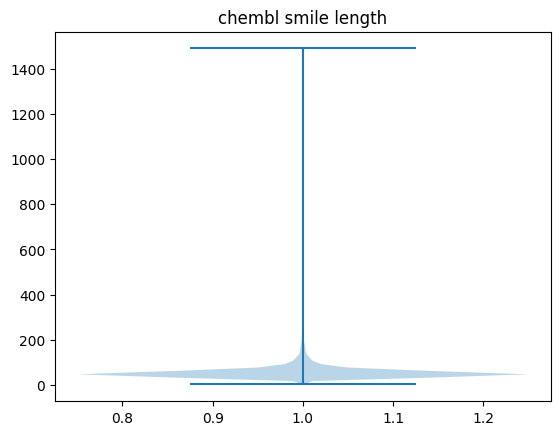

previous chembl total compound:  2131413
mean +/- std tokens : 58.506 +/- 45.148


In [35]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(10)

fig = plt.figure()

bp = plt.violinplot(lens_re)
plt.title('chembl smile length')
plt.show()

print('previous chembl total compound: ', len(lens_re))
print(f'mean +/- std tokens : {np.mean(lens_re):.3f} +/- {np.std(lens_re):.3f}')


In [4]:
smiles = {}
# smiles['test'] = max_len_smi
# smiles['remove_k'] = new
smiles['MMT3-72'] = 'O=C(NCCC(O)=O)C(C=C1)=CC=C1/N=N/C(C=C2C(O)=O)=CC=C2OCCOC3=CC=C(NC4=NC=C(C)C(NC5=CC=CC(S(NC(C)(C)C)(=O)=O)=C5)=N4)C=C3'
smiles['M1'] = 'OCCOC1=CC=C(NC2=NC=C(C)C(NC3=CC=CC(S(N)(=O)=O)=C3)=N2)C=C1'
smiles['M2'] = 'OCCOC1=CC=C(NC2=NC=C(C)C(NC3=CC=CC(S(NC(C)(C)C)(=O)=O)=C3)=N2)C=C1'
smiles['M3'] = 'OC(COC1=CC=C(NC2=NC=C(C)C(NC3=CC=CC(S(NC(C)(C)C)(=O)=O)=C3)=N2)C=C1)=O'
smiles['M4'] = 'O=C(NCCC(O)=O)C(C=C1)=CC=C1/N=N/C(C=C2C(O)=O)=CC=C2OCCOC3=CC=C(NC4=NC=C(C)C(NC5=CC=CC(S(N)(=O)=O)=C5)=N4)C=C3'
smiles['M5'] = 'OC1=CC=C(NC2=NC=C(C)C(NC3=CC=CC(S(NC(C)(C)C)(=O)=O)=C3)=N2)C=C1'

smi_list = list(smiles.values())

In [ ]:
a, b = encode(smi_list)
print(a)

In [42]:
d = torch.zeros([6, 120, 40])

In [64]:
array_to_vector(output)

torch.Size([120])
torch.Size([120])
torch.Size([120])
torch.Size([120])
torch.Size([120])
torch.Size([120])


In [52]:
# output.shape
q, w, e = output.shape

In [13]:
! pip install rdkit --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 43.7 MB/s eta 0:00:00


In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
m = Chem.MolFromSmiles
# for i in decode(daf):
#     display(m(i))


NameError: ignored

In [77]:
ef = To_matrix(a)
daf = To_vector(ef)
print('vector to matrix back to vector, still the same: ', torch.equal(daf, a))

vector to matrix back to vector, still the same:  True


In [6]:
import pandas as pd
chembl_path = '/content/drive/MyDrive/A_DATA/filtered_chembl_for_gentrl.csv'
chembl = pd.read_csv(chembl_path)

In [78]:
chembl.head()

SMILES      plogP       QED
0                       Cc1cc(-c2csc(N=C(N)N)n2)cn1C  -1.686554  0.608781
1  CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H... -25.745690  0.016357
2  CCCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(... -22.948679  0.010798
3  CC(C)C[C@@H]1NC(=O)CNC(=O)[C@H](c2ccc(O)cc2)NC... -15.732651  0.016726
4             Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1   0.679815  0.623114

In [19]:
import torch
import re


_atoms = ['He', 'Li', 'Be', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'Cl', 'Ar',
          'Ca', 'Ti', 'Cr', 'Fe', 'Ni', 'Cu', 'Ga', 'Ge', 'As', 'Se',
          'Br', 'Kr', 'Rb', 'Sr', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
          'Pd', 'Ag', 'Cd', 'Sb', 'Te', 'Xe', 'Ba', 'La', 'Ce', 'Pr',
          'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Er', 'Tm', 'Yb',
          'Lu', 'Hf', 'Ta', 'Re', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb',
          'Bi', 'At', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'Pu', 'Am', 'Cm',
          'Bk', 'Cf', 'Es', 'Fm', 'Md', 'Lr', 'Rf', 'Db', 'Sg', 'Mt',
          'Ds', 'Rg', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']


def get_tokenizer_re(atoms):
    return re.compile('('+'|'.join(atoms)+r'|\%\d\d|.)')


_atoms_re = get_tokenizer_re(_atoms)


__i2t = {
    0: 'unused', 1: '>', 2: '<', 3: '2', 4: 'F', 5: 'Cl', 6: 'N',
    7: '[', 8: '6', 9: 'O', 10: 'c', 11: ']', 12: '#',
    13: '=', 14: '3', 15: ')', 16: '4', 17: '-', 18: 'n',
    19: 'o', 20: '5', 21: 'H', 22: '(', 23: 'C',
    24: '1', 25: 'S', 26: 's', 27: 'Br' , 28: '@', 29: '/', 30: '.',
    31: 'P', 32: '+', 33: 'I', 34: 'Si', 35: 'B', 36: '\\',
    37: '7', 38: '8', 39: '9'
}
# 28: '@', 29: '/', 30: '.'

__t2i = {
    '>': 1, '<': 2, '2': 3, 'F': 4, 'Cl': 5, 'N': 6, '[': 7, '6': 8,
    'O': 9, 'c': 10, ']': 11, '#': 12, '=': 13, '3': 14, ')': 15,
    '4': 16, '-': 17, 'n': 18, 'o': 19, '5': 20, 'H': 21, '(': 22,
    'C': 23, '1': 24, 'S': 25, 's': 26, 'Br': 27 , '@': 28, '/': 29, '.': 30,
    'P': 31, '+': 32, 'I': 33, 'Si': 34, 'B': 35, '\\': 36,
    '7': 37, '8': 38, '9': 39
}
#, '@': 28, '/': 29, '.': 30

def smiles_tokenizer(line, atoms=['Cl', 'Br', 'Si', 'Na', 'Mg']):
    """
    Tokenizes SMILES string atom-wise using regular expressions. While this
    method is fast, it may lead to some mistakes: Sn may be considered as Tin
    or as Sulfur with Nitrogen in aromatic cycle. Because of this, you should
    specify a set of two-letter atoms explicitly.

    Parameters:
         atoms: set of two-letter atoms for tokenization
    """
    if atoms is not None:
        reg = get_tokenizer_re(atoms)
    else:
        reg = _atoms_re
    return reg.split(line)[1::2]


# def encode(sm_list, pad_size=120):
#     """
#     Encoder list of smiles to tensor of tokens
#     """
#     res = []
#     lens = []
#     # print(sm_list)
#     for s in tqdm(sm_list):
#         tokens = ([1] + [__t2i[tok] for tok in smiles_tokenizer(s)])
#         lens.append(len(tokens))
#         tokens = tokens[:pad_size - 1]
#         tokens += (pad_size - len(tokens)) * [2]
#         res.append(tokens)


#     return torch.tensor(res).long(), lens


def encode(sm_list, pad_size=200):
    """
    Encoder list of smiles to tensor of tokens
    """
    res = []
    lens = []
    for s in sm_list:

        tokens = ([1] + [__t2i[tok]
                for tok in smiles_tokenizer(s)])
        lens.append(len(tokens))
        tokens = tokens[:pad_size - 1]
        tokens += (pad_size - len(tokens)) * [2]
        res.append(tokens)

    return torch.tensor(res).long(), lens


def decode(tokens_tensor):
    """
    Decodes from tensor of tokens to list of smiles
    """

    smiles_res = []

    for i in range(tokens_tensor.shape[0]):
        cur_sm = ''
        for t in tokens_tensor[i].detach().cpu().numpy():
            if t == 2:
                break
            elif t > 2:
                cur_sm += __i2t[t]

        smiles_res.append(cur_sm)

    return smiles_res


def get_vocab_size():
    return len(__i2t)


In [17]:
from tqdm import tqdm
import pandas as pd
from rdkit import Chem
m_ = Chem.MolFromSmiles
s_ = Chem.MolToSmiles

In [21]:
# from tqdm import tqdm
# import pandas as pd
# chembl_path = '/content/drive/MyDrive/A_DATA/filtered_chembl_for_gentrl.csv'
# chembl = pd.read_csv(chembl_path)

# tens, lens = encode(chembl, pad_size=200)

KeyError: ignored

In [43]:
import random
N = len(chembl)
smiles_chembl_rand = random.sample(sorted(chembl.SMILES), N)


In [20]:
# import pickle
tens, lens = encode(chembl, pad_size=200)
data_save_path = '/content/drive/MyDrive/A_DATA/smile_len_200/'
torch.save(tens, data_save_path + 'tensor.pt')
with open (data_save_path+'len_list.pkl', 'wb') as f:
    pickle.dump(lens)

smiles_res = decode(tens)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

inv = []
vals = []
for i, (smi_recon, smi) in tqdm(enumerate(zip(smiles_res, smiles_chembl_rand)),
                                total=len(smiles_res)):
    try:
        smi_ = s_(m_(smi_recon))
        assert smi_recon == smi
        vals.append(smi)
    except:
        # print(i, smi)
        inv.append(i)
print(len(inv))

KeyError: ignored

In [ ]:
tens.shape

mat = To_matrix(tens)

In [40]:
a, b = encode([smiles_chembl_rand[i] for i in inv])

100%|██████████| 144/144 [00:00<00:00, 9668.94it/s]


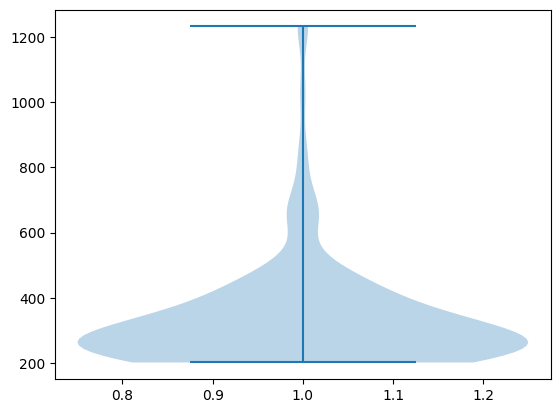

In [41]:
# a, b = encode(smiles_chembl_rand)

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(10)
# collectn_1 = np.random.normal(100, 10, 200)
# collectn_2 = np.random.normal(80, 30, 200)
# collectn_3 = np.random.normal(90, 20, 200)
# collectn_4 = np.random.normal(70, 25, 200)

## combine these different collections into a list
# data_to_plot = [collectn_1, collectn_2, collectn_3, collectn_4]

# Create a figure instance
fig = plt.figure()

# Create an axes instance
# ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = plt.violinplot(b)
plt.show()

CSCC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CO)NC(=O)[C@H](CC(=O)O)NC(C)=O)CSSC[C@@H](C(=O)N[C@@H](CC(=O)O)C(=O)N2CCC[C@H]2C(=O)N[C@@H](CCCNC(=N)N)C(N)=O)NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]2CCCN2C1=O


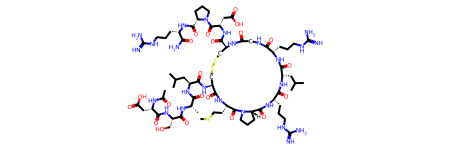

CCCC(=O)N[C@@H](CCC(=O)NCCOCCOCC(=O)NCCOCCOCC(=O)N[C@@H](CCCCNC(=N)N)C(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCCNC(=N)N)C(=O)N1CCC[C@H]1C(=O)N[C@H](CCCNC(=N)N)C(=O)N(C)[C@@H](CC(C)C)C(=O)N[C@@H](CO)C(=O)N[C@@H](Cc1c[nH]cn1)C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N1[C@H](C(=O)N[C@@H](Cc2ccc(I)cc2)C(=O)N2CCC[C@H]2C(=O)N[C@H](Cc2ccc(-c3ccccc3)cc2)C(=O)O)C[C@@H]2CCCC[C@@H]21)C(=O)O


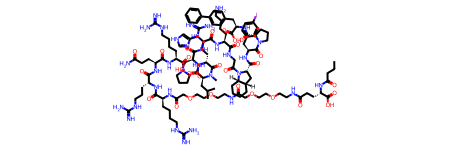

CC(C)C[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@@H](N)CO)[C@@H](C)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CO)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](C)C(=O)O)[C@@H](C)O


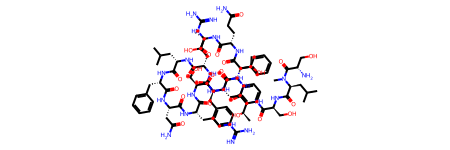

C/C=C1\NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H](C(C)C)NC(=O)[C@@H]([C@H](C)CC)NC(=O)[C@H](NC(=O)[C@H](NC(=O)[C@H](CCCN)NC(=O)[C@H]2CCCN2C(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](CCC(=O)O)NC(=O)CCCC(C)C)[C@@H](C)O)C(C)C)C(C)C)[C@H](C)CC)[C@H](C)OC(=O)[C@H](C(C)C)NC1=O


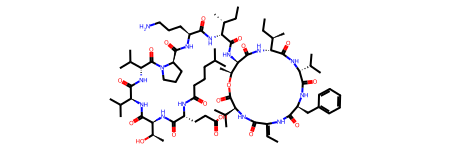

COC(=O)[C@H](CCCCNC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H](N)Cc1ccc(O)cc1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H](N)Cc1ccc(O)cc1)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H](N)Cc1ccc(O)cc1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CO)NC(=O)[C@@H](N)Cc1ccc(O)cc1


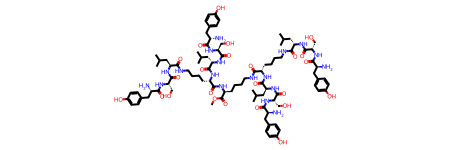

C[C@H](NC(=O)CN(CCNC(=O)CN(CCNC(=O)CN(CCNC(=O)CCC(=O)O)C(=O)Cn1ccc(N)nc1=O)C(=O)Cn1ccc(N)nc1=O)C(=O)Cn1ccc(N)nc1=O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@H](CCCNC(=N)N)C(N)=O


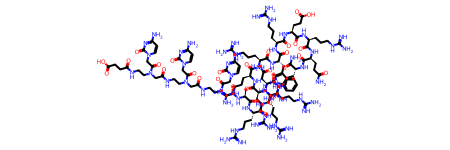

CCCCC/C=N\O[C@@H]1C[C@@H](C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(N)=O)N(C(=O)C2CCCCN2C(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@@H]2CCCN2C(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]2CCCN2C(=O)CCCCNC(=S)Nc2ccc3c(c2)C2(OC3=O)c3ccc(O)cc3Oc3cc(O)ccc32)[C@@H](C)O)C1


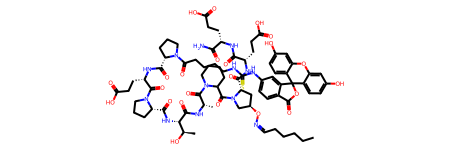

CCC(C)[C@H]1O[C@]2(C=C[C@@H]1C)C[C@@H]1C[C@@H](C/C=C(\C)[C@@H](O[C@H]3C[C@H](OC)[C@@H](O[C@H]4C[C@H](OC)[C@@](O)(CBr)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3\CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]34O)O2


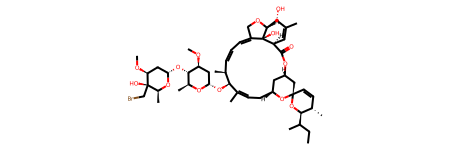

CCCC[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCC)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H](C)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N1C(=O)[C@@H](C)NC(=O)[C@H](C)NC(=O)[C@@H](N)CCC(=O)NCCCC[C@@H]1C(=O)N[C@H](CC(N)=O)C(=O)N[C@H](CCCN=C(N)N)C(=O)N[C@H](CC(C)C)C(=O)N[C@H](CC(C)C)C(=O)N[C@H](CC(C)C)C(=O)N[C@H](CCC(=O)O)C(=O)N[C@H](CCC(=O)O)C(=O)N[C@H](C)C(N)=O


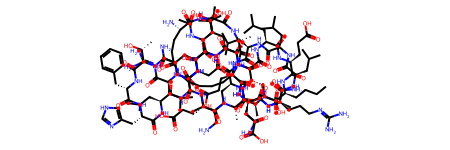

CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@H](CO)[C@@H](O[C@@H]2O[C@H](CO)[C@H](O[C@@H]3O[C@H](CO)[C@H](O)[C@H](O[C@@H]4O[C@H](CO)[C@H](O)[C@H](O)[C@H]4O)[C@H]3NC(C)=O)[C@H](O[C@]3(C(=O)OC(C)C)C[C@H](O)[C@@H](NC(C)=O)[C@H]([C@H](O)[C@H](O)CO)O3)[C@H]2O)[C@H](O)[C@H]1O)NC(=O)CCCCCCCCCCCCCCCCC


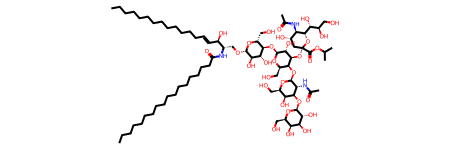

CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)N)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CO)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CO)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](C(=O)N[C@@H](CCSC)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCN=C(N)N)C(N)=O)[C@@H](C)CC)C(C)C)[C@@H](C)O


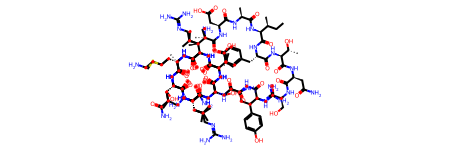

CC[C@H](C)[C@H](N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@H](C(=O)N[C@@H](CCCCN)C(=O)O)[C@@H](C)CC


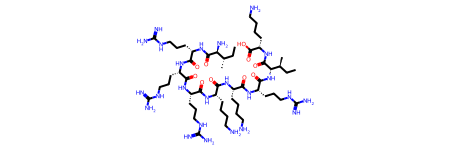

C[C@@H]1O[C@@H](O[C@@H]2[C@@H](O)[C@@H](O)[C@@H](CO)O[C@H]2O[C@@H]2C[C@H](O)CC3=CC[C@H]4[C@@H]5C[C@@H]6OC(CC[C@@H](C)CO[C@@H]7O[C@@H](C)[C@H](O)[C@@H](O)[C@H]7O)[C@@H](C)[C@@H]6[C@@]5(C)CC[C@@H]4[C@]32C)[C@H](O)[C@H](O)[C@H]1O


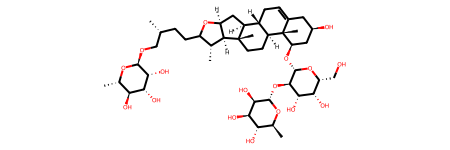

N=C(N)NCCC[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CS)NC(=O)CN)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)NCC(=O)O


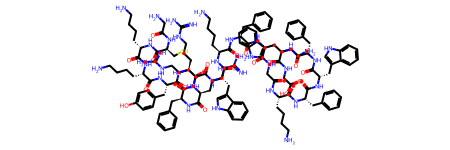

CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)C3C45CCN4CC=C[C@](CC)(C45)[C@@H](OC(=O)CC4CCN(C(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)C(NC(=O)[C@H](CO)NC(=O)[C@H](CO)NC(=O)[C@H]5CC(O)CN5C(C)=O)C5CCCCC5)C4)[C@]3(O)C(=O)OC)C2)C1.O=C(O)C(F)(F)F


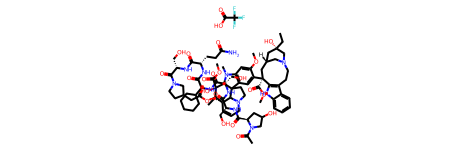

CSCC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)CCCN=C(N)N)[C@H](C)c1ccccc1)C(N)=O


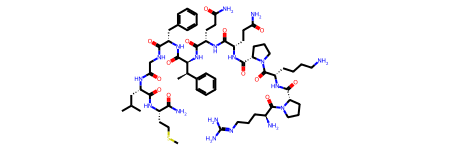

CC[C@H](C)[C@@H]1NC(=O)[C@@H]2CSSC[C@@H]3NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H]4CCCN4C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CSSC[C@H](NC(=O)[C@@H](N)CC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)NCC(=O)N[C@@H](Cc4ccccc4)C(=O)N[C@@H](CCSC)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N2)NC(=O)[C@H](CSSC[C@@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@H](C(=O)N[C@@H](Cc2ccccc2)C(N)=O)C(C)C)NC(=O)[C@H](Cc2c[nH]c4ccccc24)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc2cnc[nH]2)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC3=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]2CCCN2C1=O


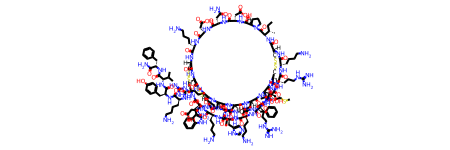

CC[C@H](C)[C@@H]1NC(=O)[C@@H]2CSSC[C@@H]3NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H]4CCCN4C(=O)[C@H](C)NC(=O)[C@H](CSSC[C@H](NC(=O)[C@@H](N)CC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)NCC(=O)N[C@@H](Cc4ccccc4)C(=O)N[C@@H](CCSC)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N2)NC(=O)[C@H](CSSC[C@@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@H](C(=O)N[C@@H](Cc2ccccc2)C(N)=O)C(C)C)NC(=O)[C@H](Cc2c[nH]c4ccccc24)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc2cnc[nH]2)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC3=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]2CCCN2C1=O


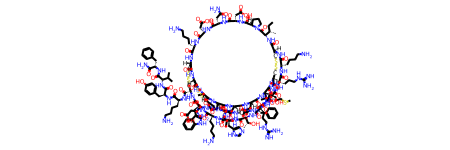

CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@@H](CC(N)=O)C(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](C(=O)N[C@@H](CC(=O)O)C(=O)NCC(=O)N[C@@H](CS)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(N)=O)C(C)C)C(C)C


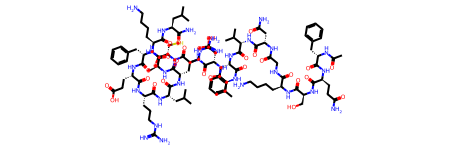

CCCC[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)CNC(=O)[C@H](Cc1ccc(O)cc1)n1cc([C@H](C)NC(=O)[C@@H](CCC(=O)O)NC(=O)CN2CCN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=O)O)CC2)nn1)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(N)=O


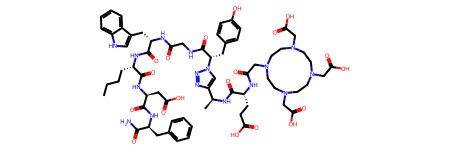

C=C[C@](C)(CC/C=C(\CO)C(=O)O[C@H]1C[C@@]2(C(=O)O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O[C@@H]3O[C@@H](C)[C@H](O[C@@H]4O[C@@H](CO)[C@H](O)[C@H]4O)[C@@H](O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)[C@H]3O)[C@@H](CC1(C)C)C1=CC[C@@H]3[C@@]4(C)CC[C@H](O[C@@H]5O[C@H](CO[C@@H]6O[C@H](C)[C@H](O)[C@H](O)[C@H]6O[C@@H]6OC[C@@H](O)[C@H](O)[C@H]6O)[C@@H](O)[C@H](O)[C@H]5O)C(C)(C)[C@@H]4CC[C@@]3(C)[C@]1(C)C[C@H]2O)O[C@@H]1O[C@H](C)[C@@H](O)[C@H](O)[C@H]1O


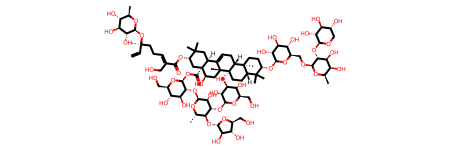

C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)CSCCNC(=S)NCCCN(C)CCCNC(=O)CCNC(=O)c1cc(NC(=O)c2cc(NC(=O)c3cc(NC(=O)c4cc(NC(=O)CCCNC(=O)c5cc(NC(=O)c6nccn6C)cn5C)cn4C)cn3C)cn2C)cn1C


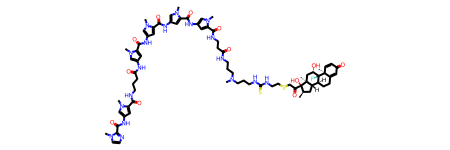

C#CC[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](C)NC(=O)[C@H](CCCCN=[N+]=[N-])NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCSC)NC(=O)[C@H](CCSC)NC(=O)CNC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(C)=O)[C@@H](C)O)[C@@H](C)O)[C@@H](C)CC)[C@@H](C)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CO)C(N)=O


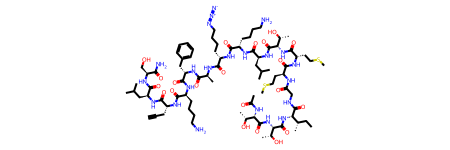

CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1ccc(Cl)cc1)C(=O)N[C@H](Cc1cccnc1)C(=O)N[C@H]1CC(=O)NC[C@@H](C(N)=O)NC(=O)[C@@H]2CCCN2C(=O)[C@@H]2CCNC(=O)[C@H](Cc3ccc(Cl)cc3)NC(=O)CC[C@H](NC1=O)C(=O)N[C@H](CCCN=C(N)N)C(=O)N[C@@H](CC(C)C)C(=O)N2


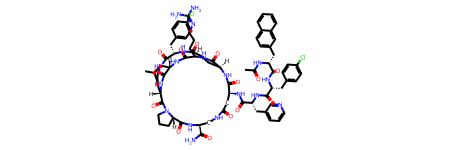

CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(OC)[C@H](N)[C@H](C)O2)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)C[C@H](N(C)C)[C@H]2OC(=O)OCC2c3ccccc3-c3ccccc32)[C@](C)(O)C[C@@H](C)N(CCF)C[C@H](C)[C@@H](O)[C@]1(C)O


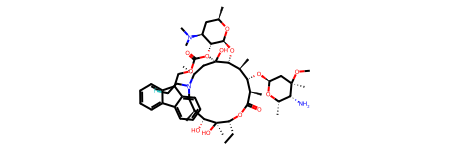

CC(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@@H]1CSSC[C@H](C(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@H](CCCNC(=N)N)C(=O)N[C@H](CCCCN)C(=O)N[C@H](CC(N)=O)C(=O)O)NC(=O)[C@@H](CCC(N)=O)NC1=O


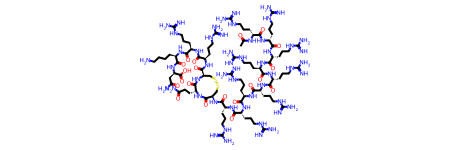

CC[C@H](C)[C@H](NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1ccccc1)NC(=O)C1CCC(NC(=O)[C@@H](N)Cc2ccc(O)cc2)CC1)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(N)=O


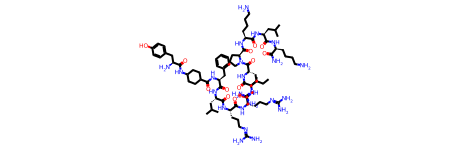

CC[C@H](C)[C@@H]1NC(=O)[C@@H]2CCCN2C(=O)[C@@H]2CCCN2C(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CO)NC(=O)[C@H](CCc2ccc([N+](=O)[O-])cc2)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)CN)CSSC[C@@H](C(=O)N[C@@H](Cc2ccccc2)C(=O)N2CCC[C@H]2C(=O)N[C@@H](CC(=O)O)C(=O)O)NC1=O


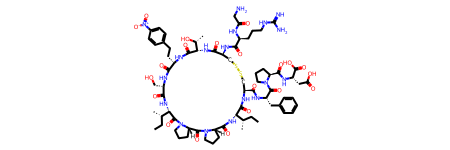

CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCSC)NC(=O)[C@@H](N)CCC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCC(N)=O)C(=O)N(C)[C@@H](CCCNC(=N)N)C(=O)O


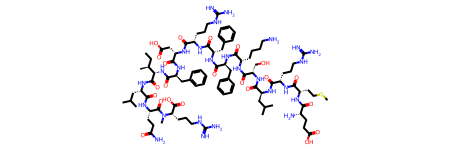

COC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](OC)[C@@H]1Cc2cc3cc(O[C@H]4C[C@@H](O[C@H]5C[C@@H](O)[C@H](O)[C@@H](C)O5)[C@H](O)[C@@H](C)O4)c(C)c(O)c3c(O)c2C(=O)[C@H]1O[C@H]1C[C@@H](O[C@H]2C[C@@H](O[C@H]3C[C@](C)(O)[C@H](O)[C@@H](C)O3)[C@H](O)[C@@H](C)O2)[C@H](O)[C@@H](C)O1


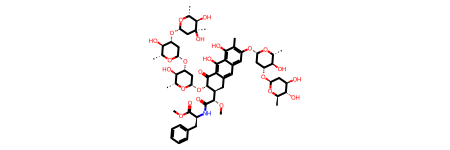

CC(C)C[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)CC[C@H](NC(=O)CCCCCCCCCCCCCCCCCCC(=O)O)C(=O)O)[C@@H](C)O)C(=O)NCC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CO)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CO)C(=O)N[C@H](C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@H](C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@H](C(=O)NCC(=O)N[C@@H](CO)C(=O)NCC(=O)N[C@@H](CO)C(=O)N[C@@H](Cc1ccc(O)cc1)C(N)=O)[C@@H](C)O)[C@@H](C)O)[C@@H](C)O


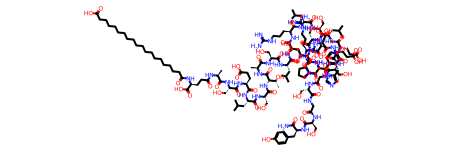

CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCN=C(N)N)NC(=O)CNC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CCCN1C(=O)CNC(=O)[C@H](CO)NC(=O)[C@@H](N)CCCN=C(N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C(=O)O)[C@@H](C)O


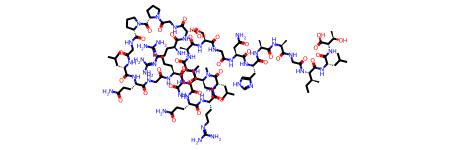

CCC(=O)NCCCCNC(=O)/N=C(\N)NCCC[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)CCCCCCC(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(N)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(N)=O


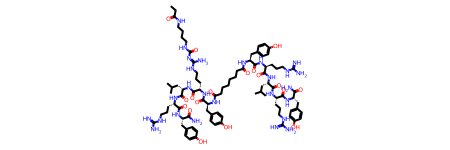

CC(=O)N[C@H]1[C@H](O[C@@H]2[C@@H](CO)O[C@@H](NC(=O)C[C@@H]3NC(=O)[C@@H](Cc4ccccc4)NC(=O)[C@H](Cc4ccccc4)NC(=O)[C@@H]4CCCN4C(=O)[C@@H](Cc4ccccc4)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCN)NC(=O)[C@H](C(C)C)NC(=O)[C@H](Cc4ccc(O)cc4)NC(=O)[C@H](CCC(N)=O)NC3=O)[C@H](NC(C)=O)[C@H]2O)O[C@H](CO)[C@@H](O)[C@@H]1O


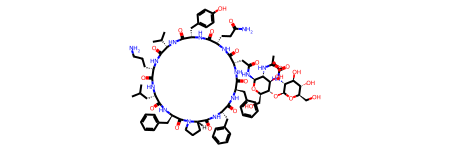

CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CSCNC(C)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(N)=O)NC(=O)[C@H](C)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CCSC)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CO)NC(C)=O)C(C)C)[C@@H](C)O)[C@@H](C)O)C(C)C)[C@@H](C)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)NCC(=O)N1CCC[C@H]1C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@H](C(=O)NCC(=O)N[C@@H](CSCC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(N)=O)C(N)=O)[C@@H](C)O


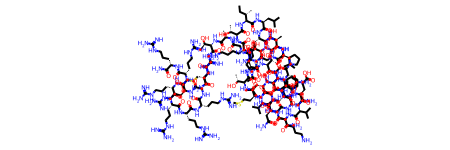

CC(C)C[C@H](N)C(=O)NCCCC[C@H](NC(=O)[C@@H](N)CC(C)C)C(=O)N[C@@H](CCC(N)=O)C(=O)NCCCC[C@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCCNC(=O)[C@@H](N)CC(C)C)NC(=O)[C@@H](N)CC(C)C)C(=O)N[C@@H](Cc1ccccc1)C(=O)NCCCC[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCCNC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCCNC(=O)[C@@H](N)CC(C)C)NC(=O)[C@@H](N)CC(C)C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](CCCCNC(=O)[C@@H](N)CC(C)C)NC(=O)[C@@H](N)CC(C)C)C(=O)N[C@@H](CCCCN)C(N)=O


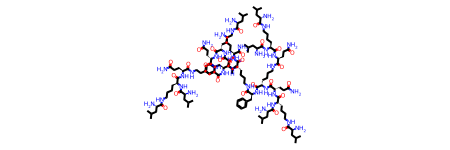

CC[C@H](C)[C@@H]1NC(=O)[C@H]([C@H](C)CC(=O)O)NC(=O)[C@@H](CO)NC(=O)CNC(=O)[C@H]([C@H](OC)C(=O)O)NC(=O)[C@@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](C)NC(=O)CN(C)C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](CCC(=O)O)NC(=O)[C@H](Cc2c[nH]c3ccccc23)NC(=O)CCCCCCCC(C)C)[C@H](O)C(N)=O)[C@H](C)OC1=O


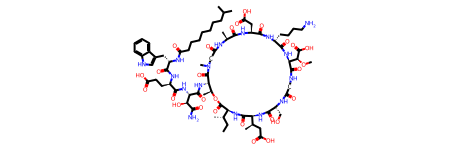

CC(=O)N[C@@H](CC(C)C)C(=O)NCCCC[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)C(=O)N[C@@H](CC(C)C)C(=O)NCCCC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(C)=O)NC(=O)[C@H](CC(C)C)NC(C)=O)C(=O)N[C@@H](Cc1ccccc1)C(=O)NCCCC[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(C)=O)NC(=O)[C@H](CC(C)C)NC(C)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCNC(=O)[C@H](CC(C)C)NC(C)=O)NC(=O)[C@H](CC(C)C)NC(C)=O)C(=O)N[C@@H](CCCCN)C(N)=O


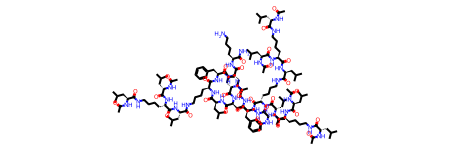

C[C@H]1[C@H]2[C@H](C[C@]3(C(=O)C[C@H]4[C@H]3CC[C@H]3Cc5nc6c(nc5C[C@@]34C)C[C@@H]3C[C@H](O)[C@H]4C5=C[C@@H]7O[C@]8(CC[C@](C)(O)CO8)[C@@H](C)[C@]7(O)[C@@]5(C)[C@H](O)C[C@@H]4[C@@]3(C)C6)[C@@]2(C)O)O[C@@]12CCC(C)(C)O2


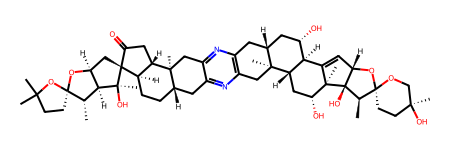

CCCCC[C@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)CNC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)Cc1ccc(O)cc1)[C@@H](C)CC)C(C)C)C(C)C)[C@@H](C)CC)C(=O)N[C@H](C(=O)N[C@@H](CCC(=O)O)C(=O)O)[C@@H](C)O


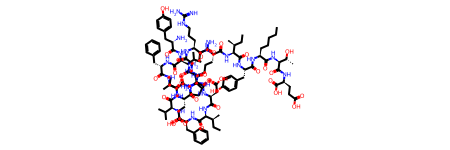

CC[C@H](C)[C@H](NC(=O)CN)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CO)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(N)=O)[C@@H](C)CC)[C@@H](C)CC


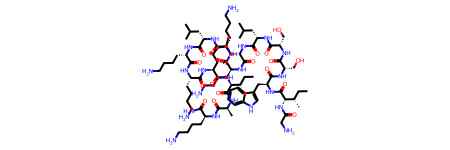

CC(=O)N[C@@H](Cc1ccc2ccccc2c1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CO)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCCNCc1ccc(O)cc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CC(C)C)C(=O)N1CCC[C@@H]1C(=O)N[C@@H](C)C(N)=O


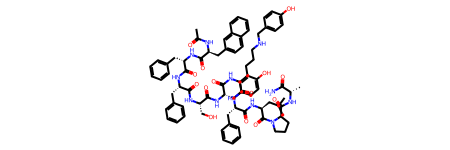

CC[C@H](C)[C@@H]1NC(=O)CNC(=O)[C@H](CCCNC(=N)N)NC(=O)CNC(=O)[C@H]([C@@H](C)O)NC(=O)[C@@H](NC(=O)[C@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](C)NC(=O)[C@@H]2CCCN2C(=O)[C@H](CC(N)=O)NC(=O)[C@@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]2CCCN2C(=O)[C@@H](N)[C@@H](C)O)[C@@H](C)CC)CSSC[C@@H](C(=O)N[C@H](C(=O)NCC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc2ccccc2)C(N)=O)C(C)C)NC(=O)[C@H](CCCNC(=N)N)NC1=O


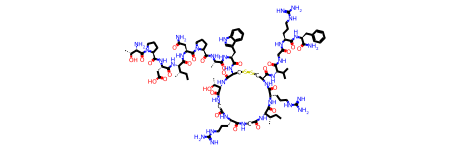

CC1=C(CC[C@@H](C)CO[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)O[C@H]2C[C@H]3[C@@H]4CC=C5C[C@@H](O[C@@H]6O[C@H](CO)[C@@H](O[C@@H]7O[C@@H](C)[C@H](O[C@@H]8O[C@@H](C)[C@H](O)[C@@H](O)[C@H]8O)[C@@H](O)[C@H]7O)[C@H](O)[C@H]6O[C@@H]6O[C@@H](C)[C@H](O)[C@@H](O)[C@H]6O)CC[C@]5(C)[C@H]4CC[C@]3(C)[C@@H]12


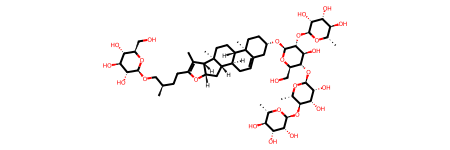

CC(=O)N[C@H]1[C@@H](O[C@@H]2[C@@H](C(=O)[O-])O[C@@H](O[C@@H]3[C@@H](COS(=O)(=O)[O-])O[C@H](O[C@H]4[C@H](O)[C@@H](OS(=O)(=O)[O-])[C@H](O[C@@H]5[C@H]6CO[C@@H](O6)[C@@H](NS(=O)(=O)[O-])[C@H]5O)O[C@H]4C(=O)[O-])[C@H](NS(=O)(=O)[O-])[C@H]3OS(=O)(=O)[O-])[C@H](O)[C@H]2O)O[C@H](COS(=O)(=O)[O-])[C@@H](O[C@@H]2O[C@@H](C(=O)[O-])[C@@H](O[C@H]3O[C@H](COS(=O)(=O)[O-])[C@@H](O[C@@H]4OC(C(=O)[O-])=C[C@H](O)[C@H]4OS(=O)(=O)[O-])[C@H](O)[C@H]3NS(=O)(=O)[O-])[C@H](O)[C@H]2O)[C@@H]1O


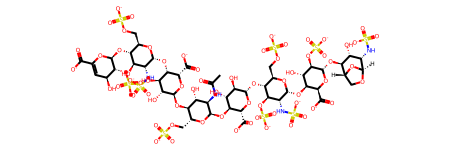

C=Cc1nc(N)nc2c1ncn2CC(=O)N(CCN)CC(=O)NCCN(CC(=O)NCCN(CC(=O)NCCN(CC(=O)NCCN(CC(=O)NCCN(CC(=O)NCCN(CC(=O)NCCN(CC(=O)NCCN(CC(=O)NCCN(CC(=O)NCCN(CC(=O)NCCN(CC(=O)NCCN(CC(=O)N[C@@H](CCCNC(=N)N)C(=O)O)C(=O)Cn1ccc(N)nc1=O)C(=O)Cn1ccc(N)nc1=O)C(=O)Cn1cc(C)c(=O)[nH]c1=O)C(=O)Cn1ccc(N)nc1=O)C(=O)Cn1cnc2c(N)ncnc21)C(=O)Cn1ccc(N)nc1=O)C(=O)Cn1cnc2c(N)ncnc21)C(=O)Cn1ccc(N)nc1=O)C(=O)Cn1cc(C)c(=O)[nH]c1=O)C(=O)Cn1cnc2c(=O)[nH]c(N)nc21)C(=O)Cn1cc(C)c(=O)[nH]c1=O)C(=O)Cn1cc(C)c(=O)[nH]c1=O


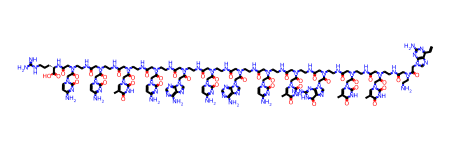

CSCC[C@H](NC(=O)[C@@H](CC(C)C)NC(=O)CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](CCC(N)=O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CCCN=C(N)N)C(=O)O


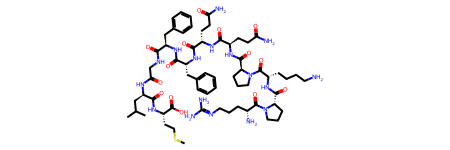

CC[C@H](C)[C@@H]1NC(=O)[C@@H]2CSSC[C@@H]3NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc4c[nH]c5ccccc45)NC(=O)[C@@H]4CCCN4C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CSSC[C@H](NC(=O)[C@@H](N)CC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)NCC(=O)N[C@@H](Cc4ccccc4)C(=O)N[C@@H](CCSC)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N2)NC(=O)[C@H](CSSC[C@@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@H](C(=O)N[C@@H](Cc2ccccc2)C(N)=O)C(C)C)NC(=O)[C@H](Cc2c[nH]c4ccccc24)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc2cnc[nH]2)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC3=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]2CCCN2C1=O


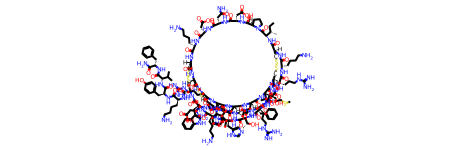

CSCC[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)CNC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](C)NC(=O)[C@@H](CCC(N)=O)NC(=O)[C@@H](CCC(N)=O)NC(=O)[C@@H](CCC(N)=O)NC(=O)[C@@H](CCC(N)=O)NC(=O)[C@@H](CCC(N)=O)NC(=O)[C@@H](CCC(N)=O)NC(=O)CN1CCN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=O)O)CC1)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(N)=O


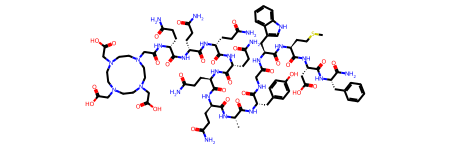

CN[C@H](CC(C)C)C(=O)N[C@@H]1C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H]2C(=O)N[C@H]3C(=O)N[C@](C)(C(=O)N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](C[C@H]3C[C@](C)(N)[C@@H](O)[C@H](C)O3)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@@H]2C[C@](C)(Nc3ccc(-c4ccccc4)cc3)[C@@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O


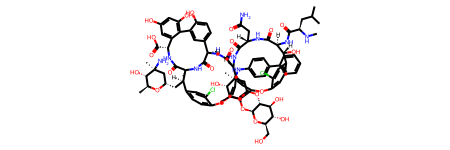

CCCC[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1ccc(OS(=O)(=O)O)cc1)NC(=O)[C@H](CC(=O)O)NC(=O)COCCOCCNC(=O)COCCOCCNC(=O)CC[C@H](NC(=O)CCCCCCCCCCCCCCCCC(=O)O)C(=O)O)C(=O)N(C)[C@H](CC(=O)O)C(=O)N(C)[C@@H](Cc1cccc2ccccc12)C(N)=O


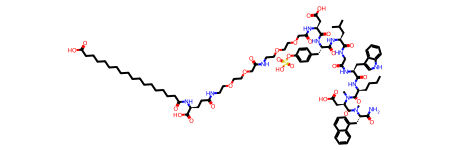

O=S(=O)(O)OC[C@@H]1O[C@H](O[C@@H]2[C@H](O[C@@H]3[C@H](COS(=O)(=O)O)O[C@H](O[C@H]4O[C@@H](COS(=O)(=O)O)[C@H](OS(=O)(=O)O)[C@H](OS(=O)(=O)O)[C@@H]4OS(=O)(=O)O)[C@@H](OS(=O)(=O)O)[C@H]3OS(=O)(=O)O)O[C@@H](COS(=O)(=O)O)[C@@H](OS(=O)(=O)O)[C@@H]2OS(=O)(=O)O)[C@@H](OS(=O)(=O)O)[C@@H](OS(=O)(=O)O)[C@H]1OS(=O)(=O)O


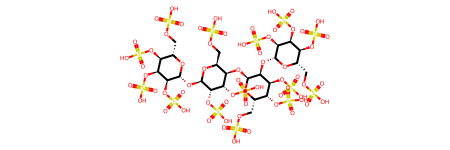

CCCCCCCCO[C@@H]1[C@@H](OCCCCCCCC)[C@@H](OC)O[C@H](COCCOCCOCCOCCOCc2cn([C@H]3C(=O)N[C@@H]4Cc5ccc(c(Cl)c5)Oc5cc6cc(c5O)Oc5ccc(cc5Cl)[C@@H](O[C@@H]5O[C@H](CO)[C@@H](O)[C@H](O)[C@H]5NC(C)=O)[C@@H]5NC(=O)[C@H](NC(=O)[C@@H]6NC(=O)[C@@H](NC4=O)c4cc(O)cc(c4)Oc4cc3ccc4O)c3ccc(O)c(c3)-c3c(O)cc(O)cc3[C@H](C(=O)O)NC5=O)nn2)[C@H]1OCc1ccc(OC)cc1


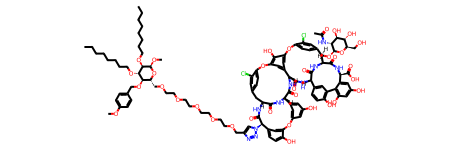

CC(C)C[C@@H]1NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](Cc2cnc[nH]2)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H]2CSCc3cc(cc(c3)CSC[C@@H](C(=O)N[C@@H](C)C(=O)O)NC1=O)CSC[C@H](NC(=O)[C@H](C)N)C(=O)N[C@@H](CO)C(=O)N[C@@H](Cc1c[nH]c3ccccc13)C(=O)N1CCC[C@H]1C(=O)N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N2


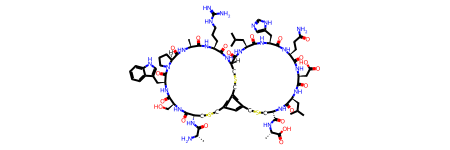

CC(=O)N[C@H]1[C@@H](OC[C@H]2O[C@H](NC(=S)NC/C=C/CNC(=S)N[C@H]3O[C@H](CO[C@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4NC(C)=O)[C@@H](O[C@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4NC(C)=O)[C@H](O[C@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4NC(C)=O)[C@H]3NC(C)=O)[C@H](NC(C)=O)[C@@H](O[C@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3NC(C)=O)[C@@H]2O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2NC(C)=O)O[C@H](CO)[C@@H](O)[C@@H]1O


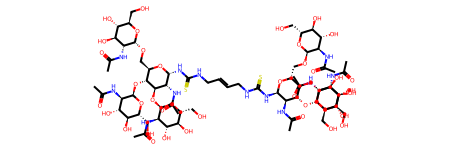

CC(=O)NCC(=O)N[C@@H](CCC(=N)N)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@@H](CC(N)=O)C(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](C(=O)N[C@@H](CC(=O)O)C(=O)NCC(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(N)=O)C(C)C)C(C)C


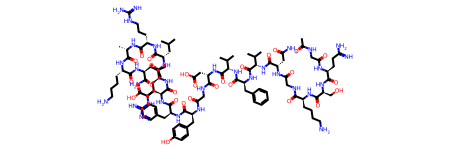

CSCC[C@@H]1NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCSC)NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(C)=O)CSSC[C@@H](C(=O)N[C@@H](CO)C(=O)N[C@H](C(=O)N[C@@H](Cc2c[nH]c3ccccc23)C(=O)N[C@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc2ccccc2)C(N)=O)C(C)C)C(C)C)NC(=O)[C@H](CCSC)NC(=O)[C@H]([C@@H](C)O)NC(=O)CNC(=O)[C@H](CCCCN)NC1=O


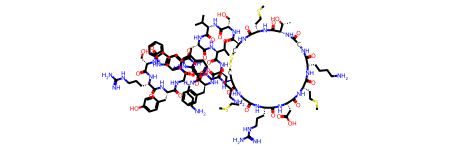

CCC(C)[C@H]1O[C@]2(C=C[C@@H]1C)C[C@@H]1C[C@@H](C/C=C(\C)[C@@H](O[C@H]3C[C@H](OC)[C@@H](O[C@H]4C[C@H](OC)[C@H](NC(=O)c5ccccc5)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3\CO[C@@H]4[C@H](O)C(C)=C[C@@H](C(=O)O1)[C@]34O)O2


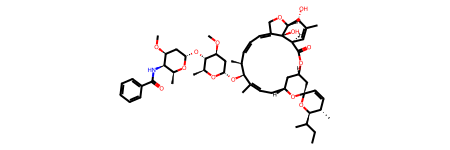

CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H](NC(=O)[C@H](CS)NC(=O)[C@H](CC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CS)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCSC)NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CS)NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CS)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)CS)C(C)C)C(C)C)C(=O)NCC(=O)N[C@@H](CS)C(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)O


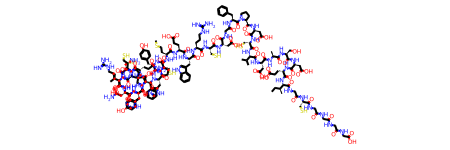

CC(C)c1cc(-c2ccc(F)cc2)nn2cc(C(=O)N3CCN(C(=O)CCC(=O)NCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOCCn4cc(CCC(=O)NCC[C@H](NC(=O)[C@H](Cc5ccc(F)c(F)c5)NC(=O)Nc5ccc6c(CN7CCCC7)nn(Cc7c(Cl)cccc7Cl)c6c5)C(=O)NCc5ccccc5)nn4)CC3(C)C)nc12


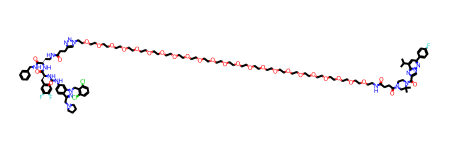

Cc1cn([C@H]2C[C@H](OP(O)(=S)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4ccc(N)nc4=O)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4ccc(N)nc4=O)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4cnc5c(=O)[nH]c(N)nc54)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4ccc(N)nc4=O)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4cnc5c(=O)[nH]c(N)nc54)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4cc(C)c(=O)[nH]c4=O)C[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4cnc5c(=O)[nH]c(N)nc54)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4ccc(N)nc4=O)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4cnc5c(=O)[nH]c(N)nc54)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4ccc(N)nc4=O)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4ccc(N)nc4=O)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4ccc(N)nc4=O)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4cc(C)c(=O)[nH]c4=O)C[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4ccc(N)nc4=O)[C@H](O)[C@@H]3OP(O)(=S)OC[C@H]3O[C@@H](n4ccc(=O)[nH]c4=O)[C@H](NCCCNCCCCNCCCN)[C@@H]3

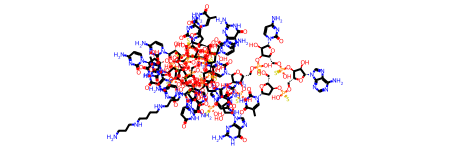

CC[C@H](C)[C@@H]1NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2cnc[nH]2)NC(=O)[C@H](C(C)C)NC(=O)[C@H](C(C)C)NC(=O)[C@@H]2CCCN2C(=O)[C@H](C(N)=O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]2CCCN2C(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]2CCCN2C(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](C(C)C)NC1=O


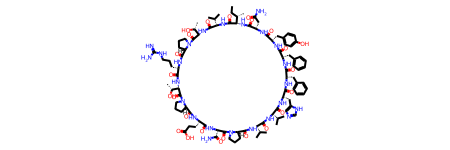

N=C(N)NCCCC[C@H](NC(=O)[C@H](CCCCNC(=N)N)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H](CCCN)NC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](CCCCNC(=N)N)NC(=O)[C@H](N)CCCN)C(N)=O


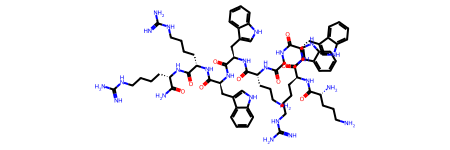

N=C(N)NCCC[C@H](N)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)O


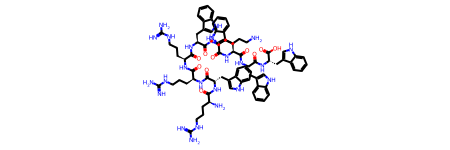

CC(=O)NCCCC[C@H](NC(=O)[C@](C)(CCCCN)NC(=O)[C@](C)(Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1ccc(OCCN)cc1)NC(=O)[C@@H]1CSCC[C@H](NC(C)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H](Cc2c[nH]c3ccccc23)C(=O)N[C@@H](CCC(N)=O)C(=O)N1)C(=O)N[C@@H](CC(N)=O)C(=O)NCC(N)=O


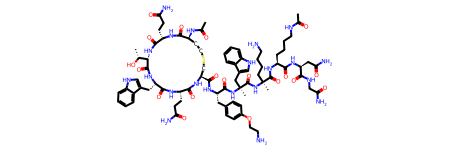

CC(=O)NC1CC/C=C\CCCC(C(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](Cc2c[nH]c3ccccc23)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc2ccccc2)C(=O)NCC(=O)NCCOCC(=O)N[C@H](CCCCN)C(N)=O)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCCNC(=N)N)NC1=O


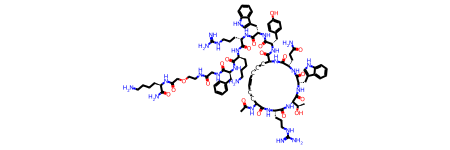

C=C(C)[C@@H]1CC[C@]2(C(=O)OC(=O)[C@]34CC[C@@H](C(=C)C)[C@@H]3[C@H]3CC[C@@H]5[C@@]6(C)C=C(C#N)C(=O)C(C)(C)[C@@H]6CC[C@@]5(C)[C@]3(C)CC4)CC[C@]3(C)[C@H](CC[C@@H]4[C@@]5(C)C=C(C#N)C(=O)C(C)(C)[C@@H]5CC[C@]43C)[C@@H]12


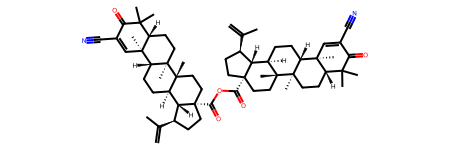

CC[C@H](C)[C@H](NC(=O)[C@]1(C)CCC/C=C/CCC[C@](C)(NC(=O)CNC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCNC(=N)N)NC(C)=O)C(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H]([C@@H](C)O)C(=O)N1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)NCC(=O)N[C@@H](CC(N)=O)C(N)=O)[C@@H](C)O


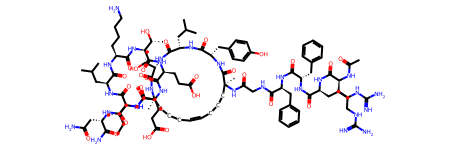

C[C@@H]1C(=O)O[C@H]2C[C@H]3[C@@H]4CC=C5C[C@@H](O[C@@H]6O[C@H](CO)[C@H](O[C@@H]7O[C@H](CO)[C@@H](O)[C@H](O[C@@H]8OC[C@@H](O)[C@H](O)[C@H]8O)[C@H]7O[C@@H]7O[C@H](CO)[C@@H](O)[C@H](O[C@@H]8O[C@H](CO)[C@@H](O)[C@H](O)[C@H]8O)[C@H]7O)[C@H](O)[C@H]6O)[C@H](O)C[C@]5(C)[C@H]4CC[C@]3(C)[C@H]21


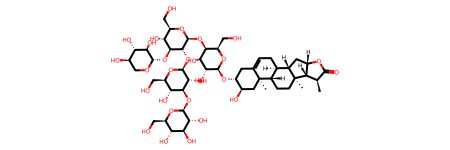

C[C@@H]1O[C@@H](O[C@H]2[C@H](O[C@H]3CC[C@@]4(C)[C@@H](CC[C@]5(C)[C@@H]4CC=C4[C@@H]6CC(C)(C)CC[C@]6(C(=O)OCCCO)CC[C@]45C)C3(C)C)OC[C@H](O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O


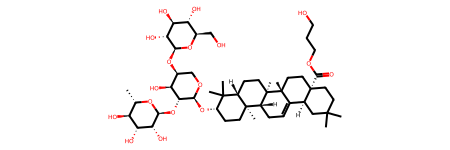

CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCN=C(N)N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCN=C(N)N)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCN=C(N)N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCCN)NC(=O)CCCN)C(C)C)[C@@H](C)O)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@H](C=O)C(C)C


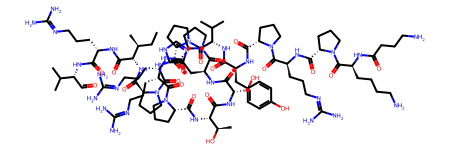

CC[C@H](C)[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](CCCCN)NC(C)=O)C(=O)NCC(=O)N[C@@H](CCCCN)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(N)=O)C(C)C


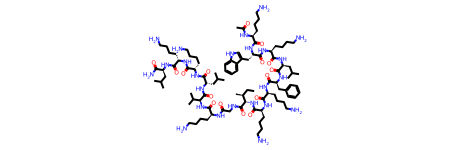

CC[C@H](C)[C@@H]1NC(=O)[C@H]2CCCN2C(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H]2CCCN2C(=O)[C@H](Cc2c[nH]cn2)NC(=O)[C@@H](CO)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H]2CCCN2C(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H]2CCCN2C(=O)[C@H](CO)NC(=O)[C@@H](Cc2ccc(O)cc2)NC(=O)[C@@H]2CCCN2C(=O)[C@@H](CCCN=C(N)N)NC(=O)[C@@H]2CCCN2C(=O)[C@@H](CCCCN)NC(=O)CNC(=O)[C@H](C(C)C)NC(=O)[C@@H](CCCN=C(N)N)NC1=O


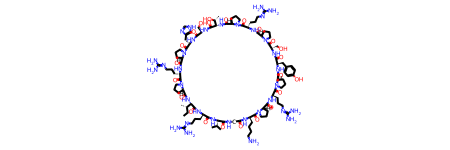

CC(=O)NC(C)(C)C(=O)NC(C)(C)C(=O)N[C@H](C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)NC(C)(C)C(=O)N[C@@H](CCCNC(=N)N)C(N)=O)[C@@H](C)O


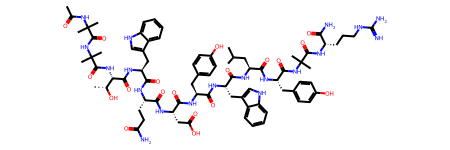

CC(=O)N[C@@H](Cc1ccc2ccccc2c1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CO)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CC(C)C)C(=O)N1CCC[C@@H]1C(=O)N[C@@H](C)C(N)=O


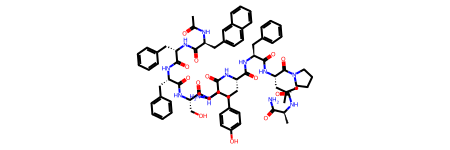

CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](C(=O)N[C@@H](CC(=O)O)C(=O)NCC(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(N)=O)C(C)C


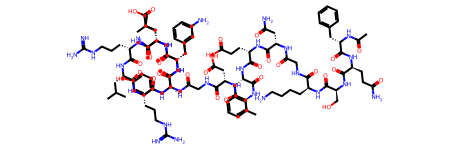

CC(=O)O[C@@]12CO[C@@H]1C[C@H](OC(=O)OC(c1ccccc1)(c1ccccc1)c1ccccc1)[C@@]1(C)C(=O)[C@H](OC(=O)OC(c3ccccc3)(c3ccccc3)c3ccccc3)C3=C(C)[C@@H](OC(=O)/C=C/c4ccc(C(=O)c5ccccc5)cc4)C[C@@](O)([C@@H](OCc4ccccc4)[C@@H]12)C3(C)C


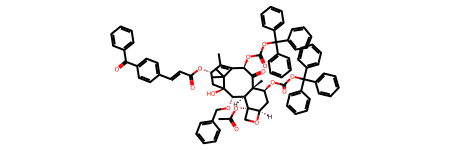

Cc1c(N)nc([C@H](CC(N)=O)NC[C@H](N)C(N)=O)nc1C(=O)N[C@H](C(=O)N[C@H](C)[C@@H](O)[C@H](C)C(=O)N[C@H](C(=O)NCCc1nc(-c2nc(C(=O)NCCCNCCCCNC(=O)[C@@H](N)C(C)C)cs2)cs1)[C@@H](C)O)[C@@H](O[C@@H]1O[C@@H](CO)[C@@H](O)[C@H](O)[C@@H]1O[C@H]1O[C@H](CO)[C@@H](O)[C@H](OC(N)=O)[C@@H]1O)c1c[nH]cn1


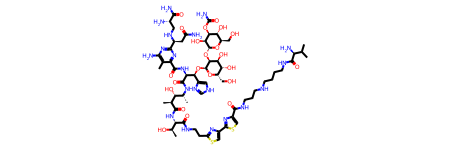

C[C@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)[C@@H](N)Cc1ccccc1)[C@@H](C)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CO)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)O


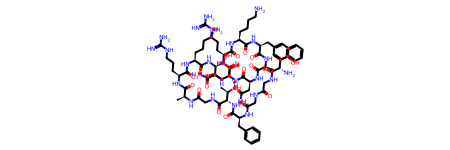

CC[C@H](C)[C@H](N)C(=O)N[C@@H](CCCCN)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)NCC(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CO)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](C)C(=O)N[C@H]1CSCC(=O)NCCN(C(=O)CCC(=O)NCCOCCOCCC(=O)NCCOCCOCCC(=O)NCCCC[C@H](NC(=O)CCCCCCCCCCCCCCCCC(=O)O)C(=O)O)CCNC(=O)CSC[C@@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc2ccc(O)cc2)C(N)=O)[C@@H](C)O)C(C)C)NC(=O)[C@@H](CC(N)=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C@H](Cc2cnc[nH]2)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CC(C)C)NC1=O


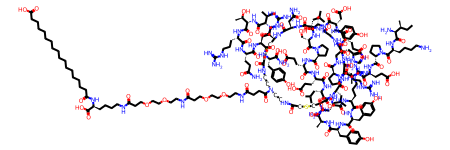

CO/C(C)=C1/NC(=O)[C@H]([C@@H](C)O)NC(=O)c2csc(n2)-c2cc(O)c(-c3nc(C(=O)N(C)CCN(C)C)cs3)nc2-c2csc(n2)[C@@H]2COC(=O)c3c4c5c(cccc5n3O)COC(=O)[C@@H](O[C@H]3C[C@](C)(O)[C@H](N(C)C)[C@H](C)O3)[C@@H](OC4)[C@H](NC(=O)c3csc1n3)c1nc(cs1)C(=O)N2.O=C(O)C(F)(F)F


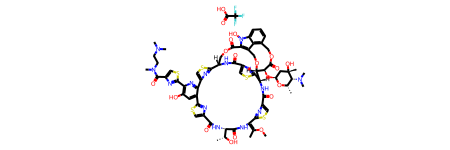

CC(C)C[C@H](NC(=O)[C@H](CO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCC(=O)O)NC(=O)C(C)(C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(N)=O)NC(=O)CCNC(=O)[C@H](Cc1ccccc1)N(C)C(=O)CNC(=O)[C@@H](C)NC(=O)[C@@H](N)Cc1ccc(O)cc1)C(N)=O


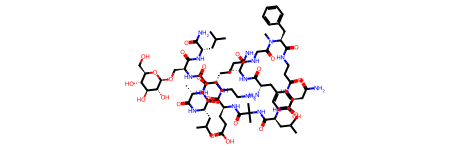

CC(=O)N[C@@H](CO)C(=O)N(C)CC(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)NC(CC1CCCCC1)C(=O)NC(CC1CCCCC1)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC(C)C)C(=O)NC(C)(C)C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)NC(CC1CCCCC1)C(N)=O)[C@@H](C)O


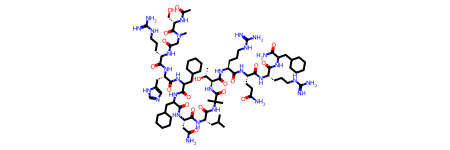

CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](N)CCCCN)[C@@H](C)CC)C(C)C)C(C)C)C(=O)O


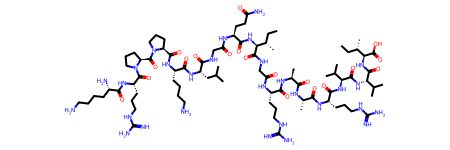

CC[C@H](C)[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H](N)CCC(=O)O)C(=O)N[C@H](C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@H](C(=O)N[C@@H](CO)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)O)C(C)C)[C@@H](C)CC


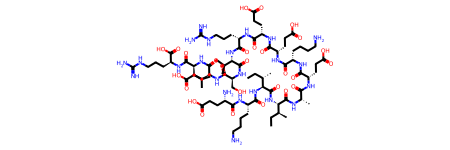

CSCC[C@@H]1NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CO)NC(C)=O)CSSC[C@@H](C(=O)N[C@H](C(=O)N[C@@H](Cc2c[nH]c3ccccc23)C(=O)N[C@H](C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc2ccccc2)C(N)=O)C(C)C)C(C)C)NC(=O)[C@H](CO)NC(=O)[C@H](C)NC(=O)[C@H]([C@@H](C)O)NC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC1=O


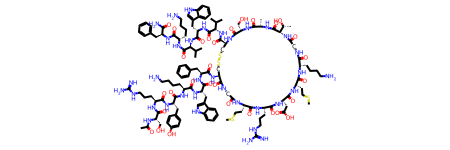

CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cccnc1)C(=O)N[C@@H](CO)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N1CCC[C@H]1C(=O)N[C@H](C)C(N)=O


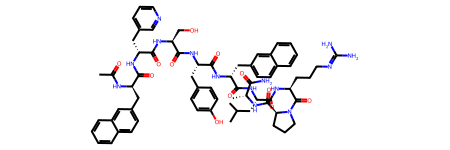

OC[C@H]1O[C@@H]2O[C@@H]3[C@@H](CO)O[C@H](O[C@@H]4[C@@H](CO)O[C@H](O[C@@H]5[C@@H](CO)O[C@H](O[C@@H]6[C@@H](CO)O[C@H](O[C@@H]7[C@@H](CO)O[C@H](O[C@H]1[C@H](O)[C@H]2O)[C@H](O)[C@H]7O)[C@H](O)[C@H]6O)[C@H](O)[C@H]5O)[C@H](O)[C@H]4O)[C@H](O)[C@H]3O


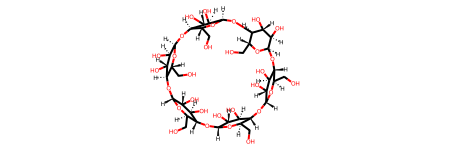

CC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)C(=O)NCC(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(N)=O)C(C)C)C(C)C


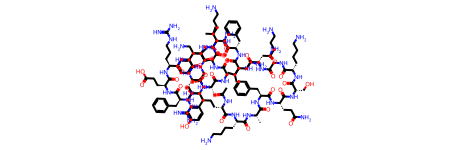

CSCC[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N)C(C)C)[C@@H](C)O)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CC(N)=O)C(=O)NCC(N)=O


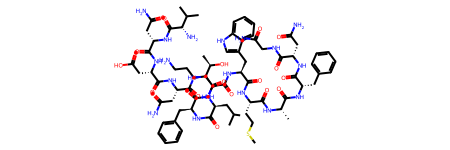

CC(C)C[C@H](N)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1ccccc1)C(=O)NCC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccccc1)C(N)=O


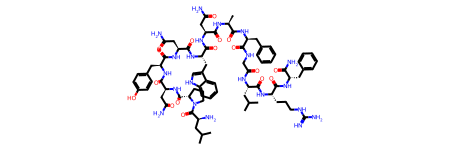

CCCN(CCc1ccc(NC(=O)CCC(N)C(=O)NCCCCC(NC(=O)CCC(=O)NCCOCCOCCNC(=O)CCC(=O)NCCOCCOCCNC(=O)CCC(=O)NCCOCCOCCNC(=O)CCC(=O)NCCOCCOCCNC(=O)CCC(=O)NCCOCCOCCNC(=O)C(CCCCNC(C)=O)NC(C)=O)C(N)=O)cc1)C1CCc2c(O)cccc2C1


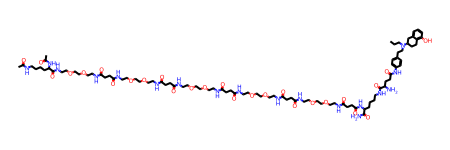

CSCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@H](CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@@H](N)CCC(N)=O)C(=O)N1CCC[C@H]1C(N)=O


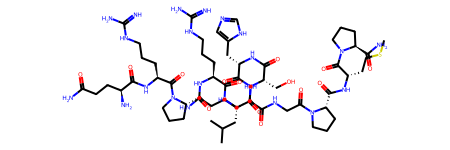

CC[C@H](C)[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCCCN)NC(=O)[C@H](C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](CCC(N)=O)NC(=O)CNC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)N)[C@@H](C)CC)C(C)C)C(C)C)C(=O)O


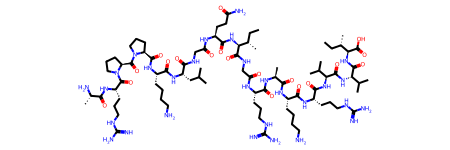

C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H]1CC[C@H](NC(=S)Nc2ccc(-c3c4ccc(=O)cc-4oc4cc(O)ccc34)c(C(=O)O)c2)CC1)C(=O)N[C@@H](CCCCNC(=O)CCc1ccc(/N=N/c2ccc(N(C)C)cc2)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1c[nH]cn1)C(=O)N[C@@H](CCCNC(=N)N)C(N)=O


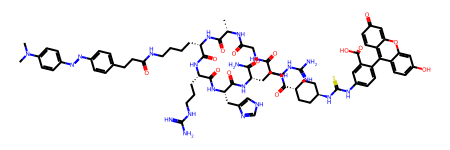

COC(=O)[C@H]1O[C@@H](O[C@H]2CC[C@@]3(C)[C@@H](CC[C@]4(C)[C@@H]3CC=C3[C@@H]5CC(C)(C)[C@@H](OC(=O)/C=C(/C)CCC=C(C)C)[C@H](OC(=O)c6ccccc6)[C@]5(CO)[C@H](O)[C@H](O)[C@]34C)C2(C)C)[C@H](O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](OC(C)=O)[C@@H]1O[C@@H]1O[C@@H](CO)[C@H](O)[C@H]1O


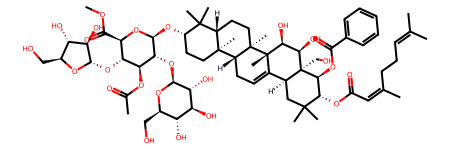

CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H]1C(=O)NCC(=O)N[C@@H](CO)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](C)C(=O)N[C@@H](CC(=O)O)C(=O)NCC(=O)N[C@H](CO)C(=O)N[C@@H]([C@@H](C)CC(=O)O)C(=O)N[C@@H](CC(=O)c2ccccc2N)C(=O)O[C@@H]1C


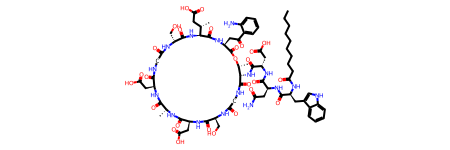

CC(=O)Nc1ccc(C[C@H](NC(=O)[C@H](CO)NC(=O)[C@@H](Cc2cccnc2)NC(=O)[C@H](NC(=O)c2c[nH]nc2N)NC(=O)[C@@H](Cc2ccc3ccccc3c2)NC(C)=O)C(=O)N[C@H](Cc2ccc(NC(C)=O)cc2)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCNC(C)C)C(=O)N2CCC[C@@H]2C(=O)N[C@H](C)C(N)=O)cc1


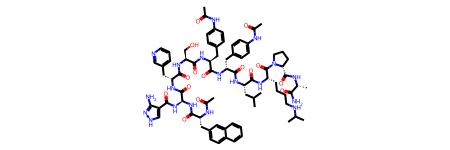

COCCOCCOCCOc1c2cc(C(C)(C)C)cc1Cc1cc(C(C)(C)C)cc(c1OCCOCCOCCOC)Cc1cc(C(C)(C)C)cc(c1OCCOCCOCCOC)Cc1cc(C(C)(C)C)cc(c1OCCOCCOCCOC)Cc1cc(C(C)(C)C)cc(c1OCCOCCOCCOC)Cc1cc(C(C)(C)C)cc(c1OCCOCCOCCOC)Cc1cc(C(C)(C)C)cc(c1OCCOCCOCCOC)Cc1cc(C(C)(C)C)cc(c1OCCOCCOCCOC)C2


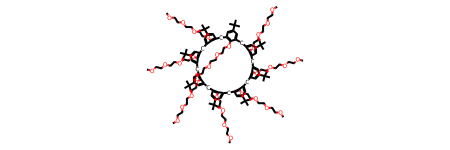

CCCCCCCCCCCCCCCC(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](C)C(=O)N[C@H](C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@H](C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(N)=O)[C@@H](C)O)[C@@H](C)O)[C@@H](C)O


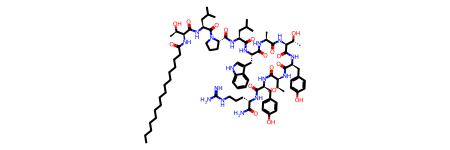

CN1/C(=C/C=C/C=C/C2=[N+](CCCCCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCCCNC(=N)Nc3ccc4[nH]c5c(c4c3)C[C@@]3(O)[C@H]4Cc6ccc(O)c7c6[C@@]3(CCN4CC3CC3)[C@H]5O7)c3ccc(S(=O)(=O)[O-])cc3C2(C)C)C(C)(C)c2cc(S(=O)(=O)O)ccc21


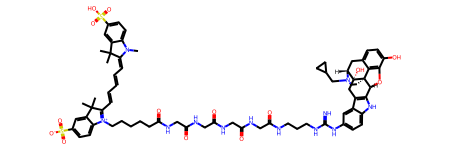

CCCCCNC(=O)CC[C@H](N)C(=O)N[C@@H](CCC(=O)NCCCCC)C(=O)N[C@@H](CCC(=O)NCCCCCO[C@H]([C@H](O)CO)[C@@H]1OC(C(=O)O)=C[C@H](N=C(N)N)[C@H]1NC(C)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCC(N)=O)C(N)=O


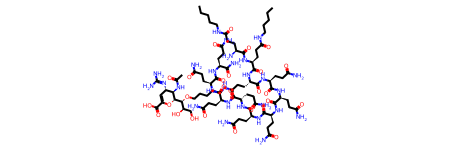

CC(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@H](C(=O)N[C@@H](CO)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)O)[C@@H](C)O)[C@@H](C)O


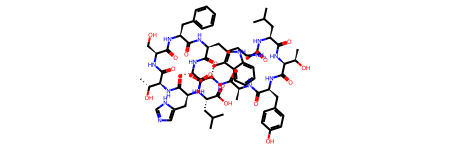

N=C(N)NCCC[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](NC(=O)[C@H](Cc2ccccc2)NC(=O)CNC(=O)CNC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)c2ccccc2)CC(=O)NCC(C(=O)N[C@@H](CCCNC(=N)N)C(=O)N2CCC[C@H]2C(=O)N[C@@H](CCCCN)C(N)=O)NC1=O


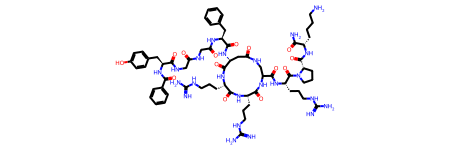

CSCC[C@@H]1NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@@H](NC(=O)[C@H](C)N)CCCCNC(=O)CC[C@@H](C(=O)N[C@@H](C)C(=O)N2CCC[C@H]2C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(N)=O)NC(=O)CNC(=O)CNC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCC(N)=O)NC1=O


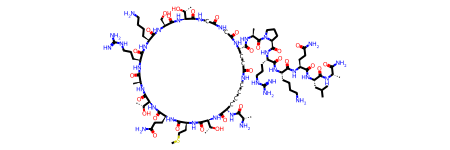

CN1CCN(c2ccc3nc(-c4ccc(OCc5cn(C[C@H]6O[C@@H](O[C@@H]7[C@@H](O)[C@H](N)C[C@H](N)[C@H]7O[C@H]7O[C@H](CN)[C@@H](O)[C@H](O)[C@H]7N)[C@H](O)[C@@H]6O[C@H]6O[C@@H](CN)[C@@H](O)[C@H](O)[C@H]6N)nn5)cc4)[nH]c3c2)CC1


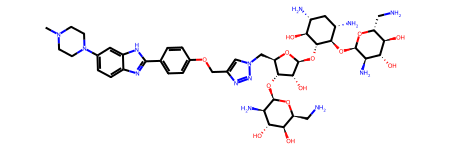

C#CC[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H](NC(=O)[C@@H]1CSSC[C@@H](NC(=O)[C@H](Cc2cnc[nH]2)NC(=O)[C@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)[C@H](CO)NC(C)=O)C(=O)N[C@@H](C)C(=O)N[C@@H](CCSC)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CCSC)C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H](CCSC)C(=O)N[C@@H]([C@@H](C)O)C(=O)N1)C(C)C)C(C)C)C(N)=O


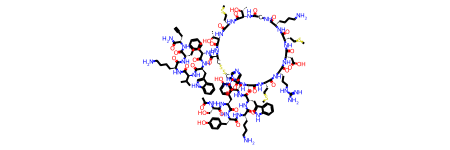

CC(=O)N[C@@H](CS)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@H](C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CS)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N(C)CC(=O)N[C@@H](CC(N)=O)C(=O)NCC(=O)NCCOCC(=O)N[C@H](CCCCN)C(N)=O)[C@@H](C)O


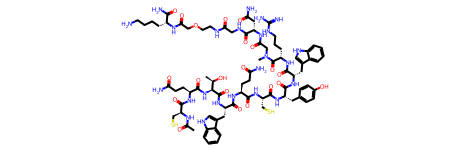

CC(C)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(N)=O)NC(=O)[C@H](CO)NC(=O)CN)[C@@H](C)O)[C@@H](C)O)[C@@H](C)O)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(=O)O


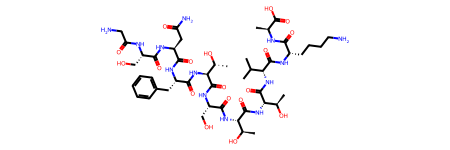

CC[C@H](C)[C@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](NC(=O)CCC(=O)N1CCN(C(=O)c2ccccc2-c2c3ccc(=[N+](CC)CC)cc-3oc3cc(N(CC)CC)ccc23)CC1)C(C)C)C(=O)N[C@H](C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCCN)C(N)=O)C(C)C.[Cl-]


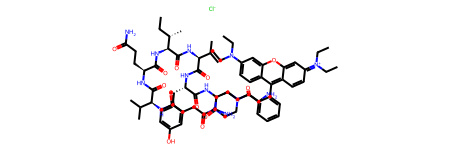

CSCC[C@H](NC(=O)[C@@H](CC(C)C)NC(=O)CNC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](CCC(N)=O)NC(=O)[C@H]1CCCN1C(=O)[C@@H](CCCCN)NC(=O)[C@H]1CCCN1C(=O)[C@@H](N)CCCN=C(N)N)C(N)=O


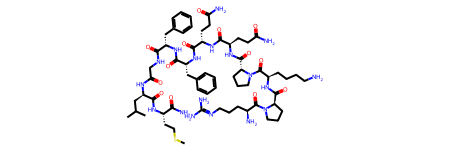

CC(=O)N[C@H]1CCC(=O)N[C@@H](C(=O)N[C@@H]2CC(=O)N[C@H](C(=O)O)CNC(=O)[C@@H]3CCCN3C(=O)[C@@H]3CCCCNC(=O)CC[C@H](NC2=O)C(=O)N[C@H](Cc2ccc4ccccc4c2)C(=O)N[C@@H](CC(C)C)C(=O)N3)CCCCNC(=O)[C@@H](Cc2ccc(Cl)cc2)NC1=O


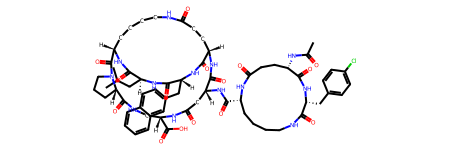

CC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CS)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@H](C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CS)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCC(C)C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(N)=O)C(=O)NCC(N)=O)[C@@H](C)O


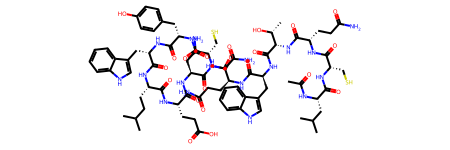

CCc1cc(OC)ccc1-c1ccc(C[C@@H]2NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@@H]3CSSC[C@@H](C(=O)O)NC(=O)[C@H](CSSC[C@H](NC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)C(C)(C)NC(=O)[C@@H](N)Cc4cnc[nH]4)C(=O)NC(C)(Cc4ccccc4F)C(=O)N3)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCc3ccccc3)NC2=O)cc1


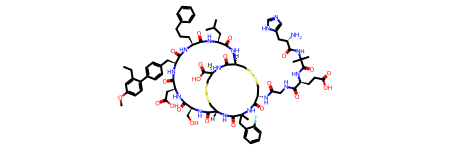

CC[C@H](C)[C@H](N)C(=O)N[C@@H](CC(C)C)C(=O)N1CCC[C@H]1C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N1CCC[C@H]1C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N1CCC[C@H]1C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N1CCC[C@H]1C(=O)N1CCC[C@H]1C(=O)NCCCCC(NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)[C@@H](C)CC)C(=O)NCCCCC(NC(=O)C(CCCCNC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H]1CCCN1C(=O)[C@H](CC(C)C)NC(=O)[C@H](N)[C@@H](C)CC)NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CCCN1C(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H

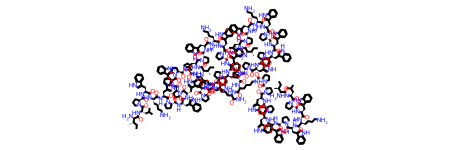

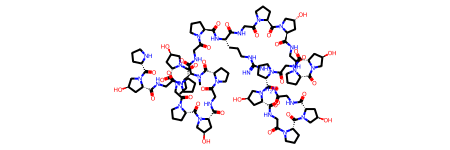

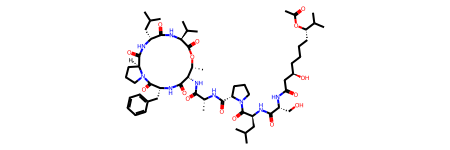

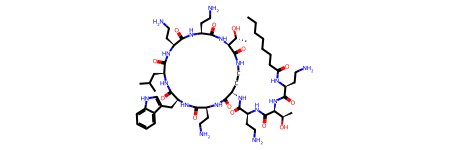

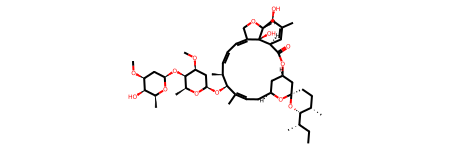

CCC[C@@H](C(=O)NCC(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)N1CCC[C@H]1C(=O)N1C[C@H](O)C[C@H]1C(=O)NCC(=O)N1CCC[C@H]1C(=O)N1C[C@H](O)C[C@H]1C(=O)NCC(=O)N1CCC[C@H]1C(=O)N1C[C@H](O)C[C@H]1C(=O)NCC(=O)N1CCC[C@H]1C(=O)N1C[C@H](O)C[C@H]1C(=O)NCC(N)=O)N(C)C(=O)[C@@H]1CCCN1C(=O)CNC(=O)[C@@H]1C[C@@H](O)CN1C(=O)[C@@H]1CCCN1C(=O)CNC(=O)[C@@H]1C[C@@H](O)CN1C(=O)[C@@H]1CCCN1C(=O)CNC(=O)[C@@H]1C[C@@H](O)CN1C(=O)[C@@H]1CCCN1
CC(=O)O[C@@H](CCCC[C@@H](O)CC(=O)N[C@H](CO)C(=O)N[C@@H](CC(C)C)C(=O)N1CCC[C@H]1C(=O)N[C@H](C)C(=O)N[C@@H]1C(=O)N[C@H](Cc2ccccc2)C(=O)N2CCC[C@H]2C(=O)N[C@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)O[C@@H]1C)C(C)C
CCCCCCCC(=O)N[C@@H](CCN)C(=O)N[C@H](C(=O)N[C@@H](CCN)C(=O)N[C@H]1CCNC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCN)NC(=O)[C@H](CCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](CCN)NC1=O)[C@@H](C)O
CC[C@H](C)[C@@H]1O[C@]2(CC[C@@H]1C)C[C@H]1C[C@H](C/C=C(\C)[C@@H](O[C@@H]3C[C@H](OC)[C@H](O[C@@H]4C[C@H](OC)[C@H](O)[C@H](C)O4)[C@H](C)O3)[C@@H](C)/C=C/C=C3CO[C@@H]4[C@@H

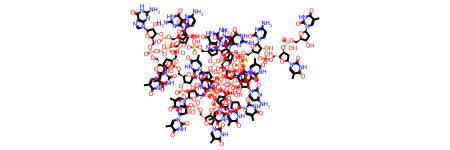

CN1Cc2c(Cl)cc(Cl)cc2[C@H](c2cccc(S(=O)(=O)NCCOCCOCCNC(=O)CCC(CCC(=O)NCCOCCOCCNS(=O)(=O)c3cccc([C@@H]4CN(C)Cc5c(Cl)cc(Cl)cc54)c3)(CCC(=O)NCCOCCOCCNS(=O)(=O)c3cccc([C@@H]4CN(C)Cc5c(Cl)cc(Cl)cc54)c3)NC(=O)Cn3ccnc3)c2)C1


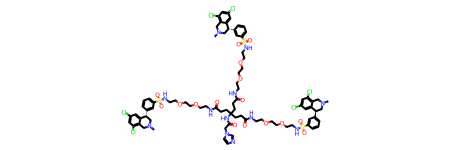

CC(=O)N[C@@H]1[C@@H]([C@H](O)[C@H](O)CO)O[C@](SCCCCCOCCCSCCC[Si](CCCSCCCOCCCCCS[C@@]2(C(=O)O)C[C@@H](O)[C@H](NC(C)=O)[C@@H]([C@H](O)[C@H](O)CO)O2)(CCCSCCCOCCCCCS[C@@]2(C(=O)O)C[C@@H](O)[C@H](NC(C)=O)[C@@H]([C@H](O)[C@H](O)CO)O2)CCCSCCCOCCCCCS[C@@]2(C(=O)O)C[C@@H](O)[C@H](NC(C)=O)[C@@H]([C@H](O)[C@H](O)CO)O2)(C(=O)O)C[C@H]1O


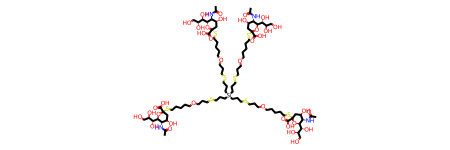

CC(C)CCC[C@@H]1CC(=O)N[C@@H](CO)C(=O)N[C@H](CC(N)=O)C(=O)N[C@@H](CO)C(=O)NCC(=O)N(C)[C@H](Cc2ccccc2)C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](CCCN)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@H](CC(N)=O)C(=O)N[C@H](Cc2c[nH]c3ccccc23)C(=O)N[C@H](Cc2c[nH]cn2)C(=O)N(C)[C@@H](C(C)C)C(=O)O1


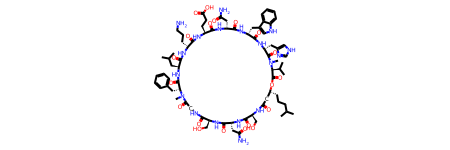

CCCC[C@H](NC(=O)[C@H](Cc1ccc(OS(=O)(=O)O)cc1)NC(=O)[C@H](CC(=O)O)NC(=O)COCCOCCNC(=O)COCCOCCNC(=O)CC[C@H](NC(=O)CCCCCCCCCCCCCCCCC(=O)O)C(=O)O)C(=O)NCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CCCC)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(N)=O


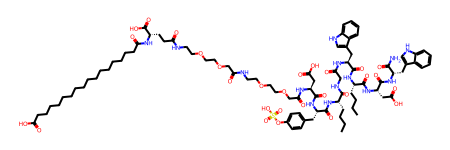

CC(C)C[C@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CO)NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](CO)NC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N)Cc1ccccc1)C(=O)O


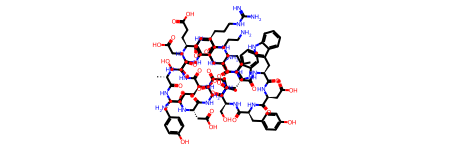

COc1ccc(C[C@H](NC(=O)[C@@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H]2CCCN2C(=O)[C@H](CCCCN)NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@H](Cc2ccccc2)NC(C)=O)C(C)C)C(=O)N[C@H](C(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](C)C(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)NC(C)(C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(N)=O)C(C)(C)C)cc1


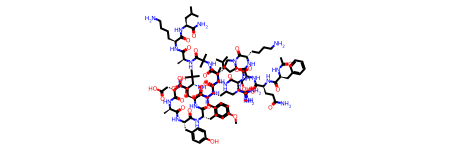

CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCCN)C(=O)NCC(=O)N[C@@H](CC(N)=O)C(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](C(=O)N[C@@H](CC(=O)O)C(=O)NCC(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC(C)C)C(N)=O)C(C)C)C(C)C


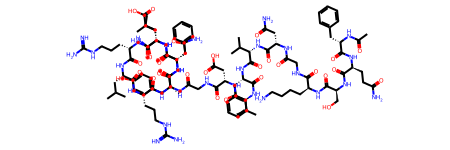

CCCCCOc1ccc(-c2ccc(-c3ccc(C(=O)N[C@H]4C[C@@H](O)[C@@H](O)NC(=O)[C@@H]5[C@@H](O)[C@@H](C)CN5C(=O)[C@H]([C@H](C)O)NC(=O)[C@H]([C@H](O)[C@@H](O)c5ccc(O)cc5)NC(=O)[C@@H]5C[C@@H](O)CN5C(=O)[C@H]([C@H](C)O)NC4=O)cc3)cc2)cc1


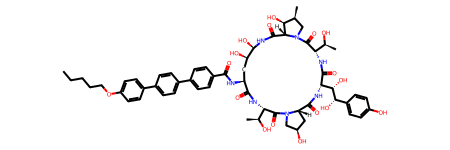

CC[C@H](C)[C@H](NC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)[C@@H](N)CCCN=C(N)N)C(=O)N[C@H](Cc1ccccc1)C(=O)N[C@@H](Cc1c[nH]cn1)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](C)C(N)=O


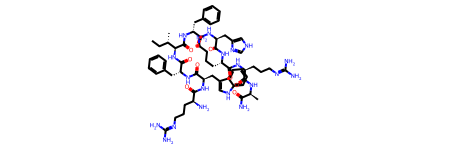

CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccccc1)C(=O)N[C@@H](CO)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@H](CCCN=C(N)N)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCCCNC(C)C)C(=O)N1CCC[C@@H]1C(=O)N[C@H](C)C(=O)O


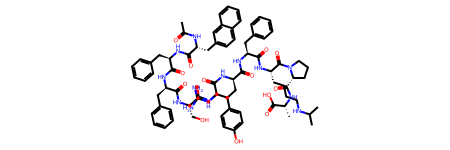

CC(=O)N[C@@H]1[C@@H](N=C(N)N)C=C(C(=O)O)O[C@H]1[C@H](OC(=O)NCCCCCCNC(=O)CC(CC(=O)NCCCCCCNC(=O)O[C@H]([C@H](O)CO)[C@@H]1OC(C(=O)O)=C[C@H](N=C(N)N)[C@H]1NC(C)=O)C(=O)NCCCCCCNC(=O)O[C@H]([C@H](O)CO)[C@@H]1OC(C(=O)O)=C[C@H](NC(=N)N)[C@H]1NC(C)=O)[C@H](O)CO


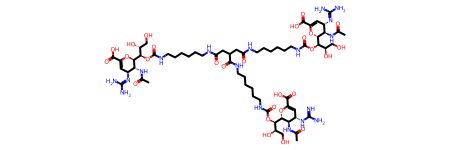

CCCC1NC(=O)[C@H](Cc2ccccc2)N(C)C(=O)[C@@H]2CCCN2C(=O)C(C(C)C)N(C)C(=O)[C@@H]2CCCN2C(=O)[C@H]([C@@H](C)CC)NC(=O)C(C(C)C)N(C)C(=O)[C@@H]2CCCN2C(=O)C(C(C)C)N(C)C(=O)C(C(C)C)N(C)C(=O)[C@H](C(C)C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C(C)C)OC(=O)C1C


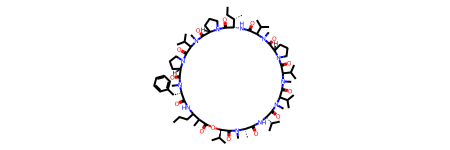

C=CCCCC[C@@H](NC(=O)[C@@H](NC(=O)[C@@H]1CCCN1C(C)=O)C(C)C)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(N)=O


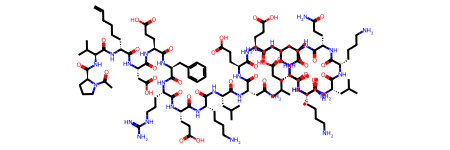

CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H]2C[C@H]1C(=O)N[C@@H](Cc1ccc3ccccc3c1)C(=O)N[C@H](C(=O)O)Cc1ccc(cc1)OC/C=C/C[C@H]1C[C@@H](C(=O)N[C@@H](Cc3ccc4ccccc4c3)C(=O)N[C@H](NS(=O)(=O)C3CC3)Cc3ccc(cc3)OCc3cn2nn3)N(C(=O)[C@@H](NC(=O)[C@H](C)NC)C(C)(C)C)C1)C(C)(C)C


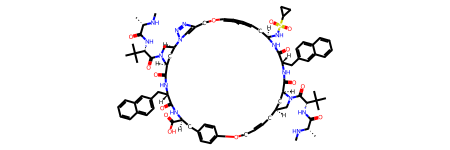

CC(C)C[C@H](NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)O


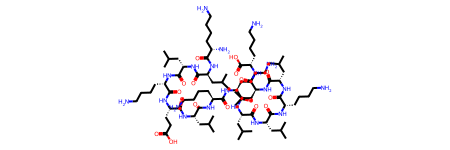

CCC(=O)[C@@H]1C[C@@H](C)[C@]2(CC[C@@]3(C)C4=C(CC[C@@]32C)[C@@]2(C)CC[C@H](O[C@@H]3O[C@H](CO[C@@H]5OC[C@H](O)[C@H](O)[C@H]5O[C@@H]5O[C@H](CO)[C@@H](O)[C@H](O[C@@H]6OC[C@H](O)[C@H](O)[C@H]6O[C@@H]6OC[C@@H](O)[C@H](O)[C@H]6O)[C@H]5O[C@@H]5O[C@@H](C)[C@H](O)[C@@H](O)[C@H]5O)[C@@H](O)[C@H](O)[C@H]3O)[C@](C)(CO)[C@@H]2CC4)O1


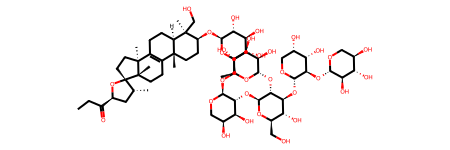

C[C@@H]1O[C@@H](O[C@H]2[C@H](OC(=O)[C@]34CCC(C)(C)C[C@@]3(C)C3=CC[C@@H]5[C@@]6(C)C[C@H](O)[C@H](O[C@@H]7O[C@H](CO)[C@@H](O)[C@H](O)[C@H]7O)[C@@](C)(C(=O)O)[C@@H]6CC[C@@]5(C)[C@]3(CO)CC4)O[C@H](C)[C@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O[C@@H]1OC[C@@H](O)[C@H](O)[C@H]1O


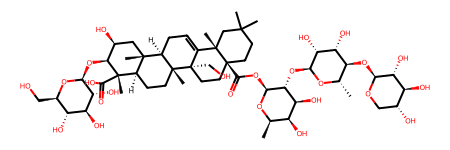

CC[C@H](C)[C@H](N)C(=O)N[C@H]1CCC(=O)NC[C@@H](C(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc2ccc(O)cc2)C(N)=O)NC(=O)[C@@H]2CCCN2C(=O)[C@@H](NC(=O)[C@@H](N)[C@@H](C)CC)CCC(=O)NC[C@@H](C(=O)N[C@@H](Cc2ccc(O)cc2)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc2ccc(O)cc2)C(N)=O)NC(=O)[C@@H]2CCCN2C1=O


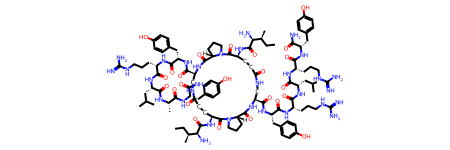

C[C@@H]1OC(=O)C[C@H](O)C[C@H](O)C[C@H](O)CC[C@@H](O)[C@H](O)C[C@]2(O)C[C@H](O)[C@@H](C(=O)O)[C@H](C[C@@H](O[C@H]3O[C@@H](C)[C@H](O)[C@@H](NCCCN)[C@H]3O)/C=C/C=C/C=C/C=C/C=C/C=C/C=C/[C@H](C)[C@@H](O)[C@H]1C)O2


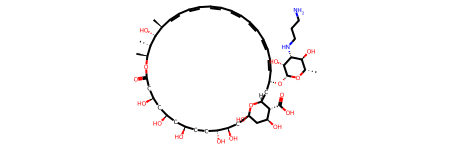

CC(C)C[C@@H]1NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H]2CCCN2C(=O)[C@@H]2CSCc3cc(cc(c3)CSC[C@@H](C(=O)NCC(=O)O)NC(=O)[C@@H]3CCCN3C(=O)[C@@H]3CCCN3C1=O)CSC[C@H](NC(=O)[C@H](C)N)C(=O)N[C@@H](Cc1c[nH]cn1)C(=O)N[C@@H](CO)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N2


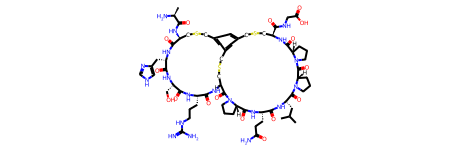

C[C@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H](Cc1cccc2ccccc12)NC(=O)CNC(=O)CNC(=O)[C@@H](N)Cc1ccccc1)[C@@H](C)O)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CO)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](CCCCN)C(N)=O


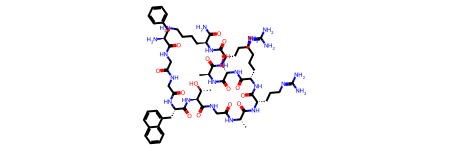

CC[C@H](C)[C@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@@H]1CCCN1C(=O)[C@H](C)N)C(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H]1CSSC[C@@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C(=O)N[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)NCC(=O)O)C(C)C)NC(=O)CNC(=O)CNC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CC(C)C)NC1=O


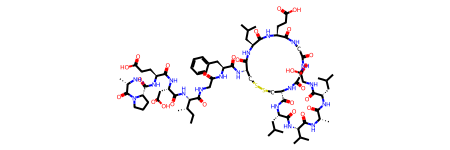

C[C@H](CC[C@@H](O[C@@H]1O[C@H](CO[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](O)[C@H](O)[C@H]1O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(C)(C)O)[C@H]1CC[C@@]2(C)[C@@H]3CC=C4[C@@H](CC[C@H](O[C@@H]5O[C@H](CO[C@@H]6O[C@H](CO)[C@@H](O)[C@H](O)[C@H]6O)[C@@H](O)[C@H](O)[C@H]5O)C4(C)C)[C@]3(C)[C@H](O)C[C@]12C


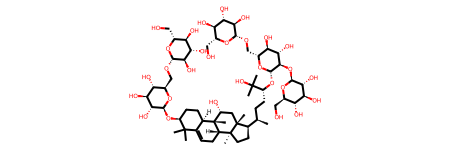

Cc1cn(CC(=O)N(CC(=O)NCCN(CC(=O)NCCN(CC(=O)NCCN(CC(=O)NC[C@@H](C)N(CC(=O)N[C@H](CCCCN)C(N)=O)C(=O)Cn2cc(C)c(=O)[nH]c2=O)C(=O)Cn2ccc(N)nc2=O)C(=O)Cn2cnc3c(N)ncnc32)C(=O)Cn2ccc(N)nc2=O)[C@H](C)CNC(=O)CN(CCNC(=O)CN(CCNC(=O)CN(CCNC(=O)CN(C(=O)Cn2cc(C)c(=O)[nH]c2=O)[C@H](C)CNC(=O)CN(CCN)C(=O)Cn2cnc3c(=O)[nH]c(N)nc32)C(=O)Cn2cnc3c(N)ncnc32)C(=O)Cn2cnc3c(=O)[nH]c(N)nc32)C(=O)Cn2cnc3c(N)ncnc32)c(=O)[nH]c1=O


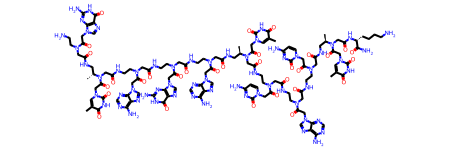

In [42]:
for i in inv:
    print(smiles_chembl_rand[i])

    display(m(smiles_chembl_rand[i]))



In [24]:
smi_test = smiles_chembl_rand[280]
v, l = encode([smi_test])

100%|██████████| 1/1 [00:00<00:00, 4424.37it/s]


In [25]:
decode(v)

['CC(=O)O[C@H]1C2[C@@](C)(CCC3C(O)(CCc4ccccc4C)C(C)=C[C@@H](OC(C)=O)[C@@]32C)C2C=CCOC[C@]2([C@@H](C)OC(C)=O)[C@H]1OC(C)=']

In [26]:
decode(v)[0] == smi_test

False

In [27]:
smi_test

'CC(=O)O[C@H]1C2[C@@](C)(CCC3C(O)(CCc4ccccc4C)C(C)=C[C@@H](OC(C)=O)[C@@]32C)C2C=CCOC[C@]2([C@@H](C)OC(C)=O)[C@H]1OC(C)=O'